<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 3: прогнозирование временных рядов</center></h2>

In [ ]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached etna-1.15.1-py3-none-any.whl (273 kB)
  Using cached tsfresh-0.20.0-py2.py3-none-any.whl (98 kB)
  Using cached gdown-4.6.4-py3-none-any.whl (14 kB)
  Using cached boto3-1.26.133-py3-none-any.whl (135 kB)
  Using cached botocore-1.29.133-py3-none-any.whl (10.7 MB)
  Using cached catboost-1.2-cp310-cp310-manylinux2014_x86_64.whl (98.6 MB)
  Using cached holidays-0.13-py3-none-any.whl (172 kB)
  Using cached pmdarima-2.0.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (1.8 MB)
  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
  Using cached tbats-1.1.3-py3-none-any.whl (44 kB)
  Using cached optuna-2.10.1-py3-none-any.whl (308 kB)
  Using cached pytorch_forecasting-0.9.2-py3-none-any.whl (113 kB)
  Using cached pyts-0.12.0-py3-none-any.whl (2.5 MB)
  Using cached wandb-0.12.21-py2.py3-none-any.whl (1.8 MB)
  Using cached stumpy-1.11.1-

In [ ]:
import warnings
import gdown
import pandas as pd
import numpy as np
import seaborn as sns
from copy import deepcopy
import matplotlib.pyplot as plt
import statsmodels.api as sm

warnings.filterwarnings("ignore")
from etna.analysis.outliers import (get_anomalies_density,
                                    get_anomalies_median,
                                    get_anomalies_prediction_interval)
from etna.analysis import (cross_corr_plot, distribution_plot, plot_anomalies,
                           plot_correlation_matrix,
                           sample_acf_plot, sample_pacf_plot)
from etna.transforms import STLTransform

from etna.analysis import (
    plot_residuals,
    acf_plot,
    get_residuals,
    stl_plot,
)
from etna.models import (CatBoostModelPerSegment, CatBoostMultiSegmentModel, ProphetModel)
from etna.transforms import (DateFlagsTransform, FilterFeaturesTransform,
                             HolidayTransform, LagTransform, MeanTransform,
                             MedianOutliersTransform, SegmentEncoderTransform,
                             TimeSeriesImputerTransform, PredictionIntervalOutliersTransform, DensityOutliersTransform)

В данной задаче мы будем решать одну из актуальных практических задач, с которыми, в том числе, сталкиваются разработчики ETNA - прогнозирование объема необходимой наличности в банкоматах (на примере одного устройства). Пожалуй, ни для кого не секрет, что отсутствие необходимой суммы в банкомате не делает клиента банка счастливее. В то же время, избыток заправленной в банкомат наличности приводит к упущенной выгоде - ведь, в конечном счете, эти деньги могли быть размещены в качестве краткосрочного депозита на межбанковском рынке. Для кредитной организации с обширной сетью банкоматов даже незначительное улучшение качества предсказания способно внести значительный вклад в прибыльность этой ветки бизнеса. 

Мы будем использовать дневные данные реального банкомата хоть и не с российского рынка, но очень схожего с ним - турецкого. Скачаем и загрузим их:

In [ ]:
url = 'https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/atm_daily_cash.csv'
output = 'atm_daily_cash.csv'
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

df = pd.read_csv('atm_daily_cash.csv')
df = df[4:] #лучше избавиться от нескольких пропущенных значений в начале сразу,
            #могут доставлять ненужные лишние проблемы

Downloading...
From: https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/atm_daily_cash.csv
To: /content/atm_daily_cash.csv
26.1kB [00:00, 15.6MB/s]                   


Взглянем на то, что представляют из себя данные:

In [ ]:
df.head()

Date   CashIn  CashOut
4  1/5/2016  20840.0  22200.0
5  1/6/2016  28460.0  18810.0
6  1/7/2016  19250.0  23210.0
7  1/8/2016  49770.0   4350.0
8  1/9/2016      NaN      NaN

В нашем распоряжении пополнения и изъятия; нас интересует нетто. Для этого будем учитывать изъятия со знаком минус, а нетто определим как сумму (такое представление пригодится нам в дальнейшем).

In [ ]:
df['CashOut'] = -df['CashOut']
df['CashNet'] = df['CashIn'] + df['CashOut']

In [ ]:
df["timestamp"] = pd.to_datetime(df["Date"], format='%m/%d/%Y')
df.drop(columns=["Date"], inplace=True)

### Задание 1. EDA (1 балл)

Проведите разведывательный анализ данных - постройте графики, на которых можно судить о наличии тренда, сезонности и прочих зависимостей. Проанализируйте корреляции. Какие выводы вы можете сделать?

In [ ]:
df.isna().sum(axis=0) # в данных есть пропущенные значения

CashIn       101
CashOut       88
CashNet      110
timestamp      0
dtype: int64

Построим графики рядов.

In [ ]:
import plotly.graph_objects as go

pal = list(sns.color_palette(palette='viridis', n_colors=3).as_hex())

fig = go.Figure()
for d,p in zip(df.columns[:3], pal):
    fig.add_trace(go.Scatter(x = df.timestamp,
                             y = df[d],
                             name = d,
                             line_color = p, 
                             fill=None))   

fig.show()

По графику видно отсутствие тренда и наличие некой сезонности в рядах (возможно, недельной или более сложной). Также ряды "колеблются" возле определенной константы (постоянство мат.ожидания) в конкретном коридоре (постоянство дисперсии). 

Посмотрим на совместные распределения рядов.

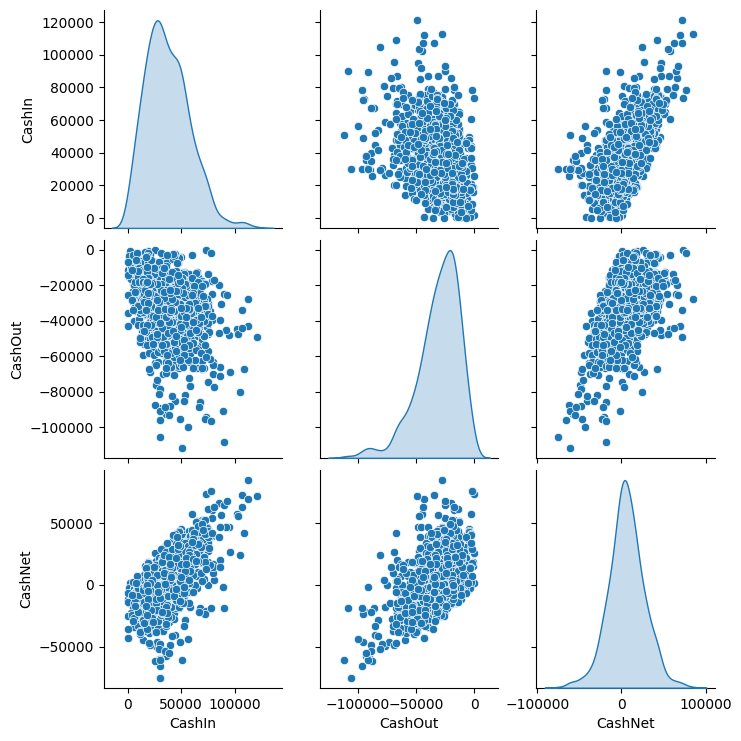

In [ ]:
sns.pairplot(df, diag_kind="kde")

Однозначных выводов о распределении данных сделать не можем, однако, можем заметить наличие корреляции.
Для этого построим корреляционную матрицу.

<Axes: >

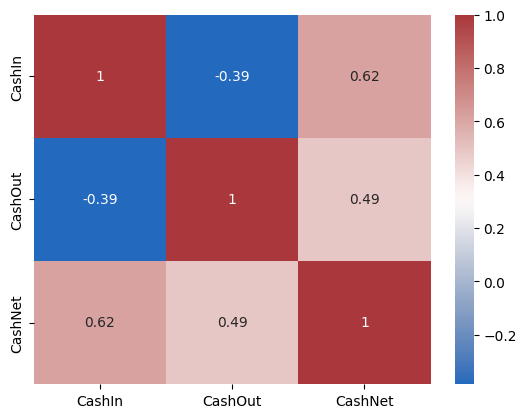

In [ ]:
cmap = sns.color_palette("vlag", as_cmap=True)
sns.heatmap(df.corr("pearson"), annot=True, cmap=cmap)

Можно отметить наличие слабой и умеренной линейной зависимости между рассматриваемыми рядами.

Построим графики ACF и PACF

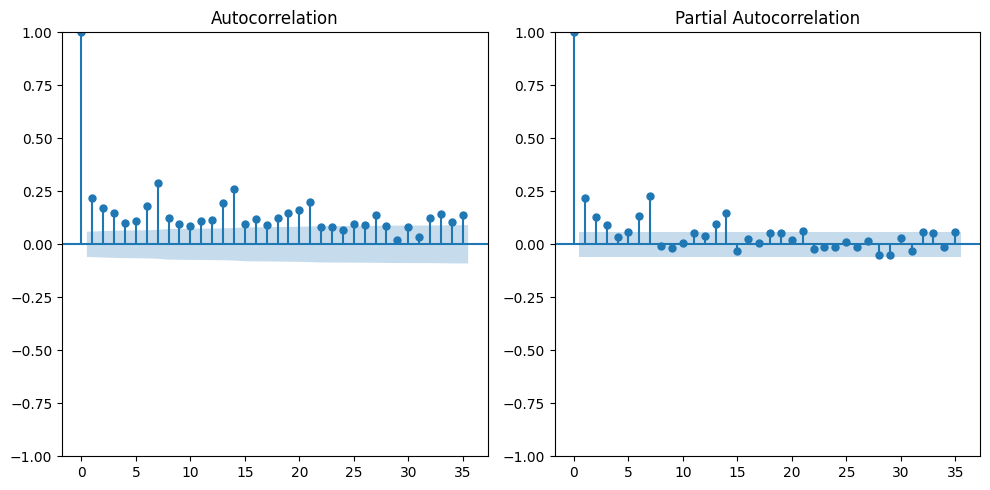

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sm.graphics.tsa.plot_acf(df.CashIn.dropna().values, lags=35, ax = axes[0])
sm.graphics.tsa.plot_pacf(df.CashIn.dropna().values, lags=35, ax = axes[1])

fig.tight_layout()

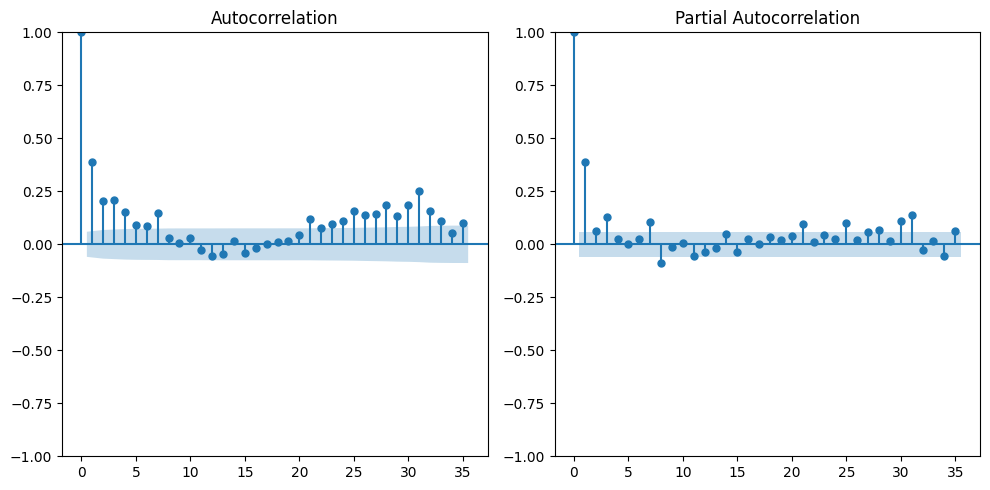

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sm.graphics.tsa.plot_acf(df.CashOut.dropna().values, lags=35, ax = axes[0])
sm.graphics.tsa.plot_pacf(df.CashOut.dropna().values, lags=35, ax = axes[1])

fig.tight_layout()

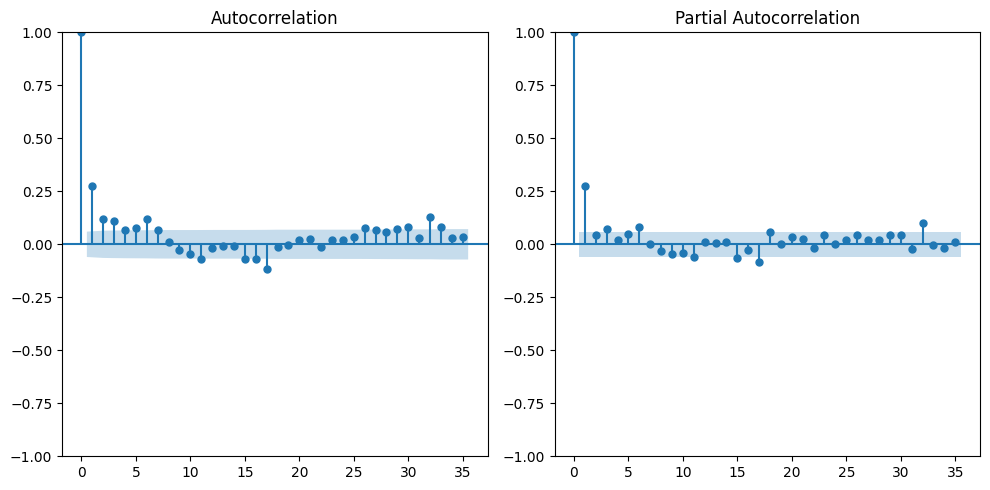

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sm.graphics.tsa.plot_acf(df.CashNet.dropna().values, lags=35, ax = axes[0])
sm.graphics.tsa.plot_pacf(df.CashNet.dropna().values, lags=35, ax = axes[1])

fig.tight_layout()

Графики ACF и PACF демонстрируют значимые корреляции даже на больших лагах. ACF обладает "волнообразным" поведением (при этом значения корреляций не затухают со временем), что может быть подтверждением факта наличия сезонности (месячной) в рядах. На графике PACF заметно выделяется каждый 7 лаг, что, вероятно, может свидетельствовать о наличии недельной сезонности.

Проведем декомпизицию рядов на тренд, сезонность и случайную составляющую.

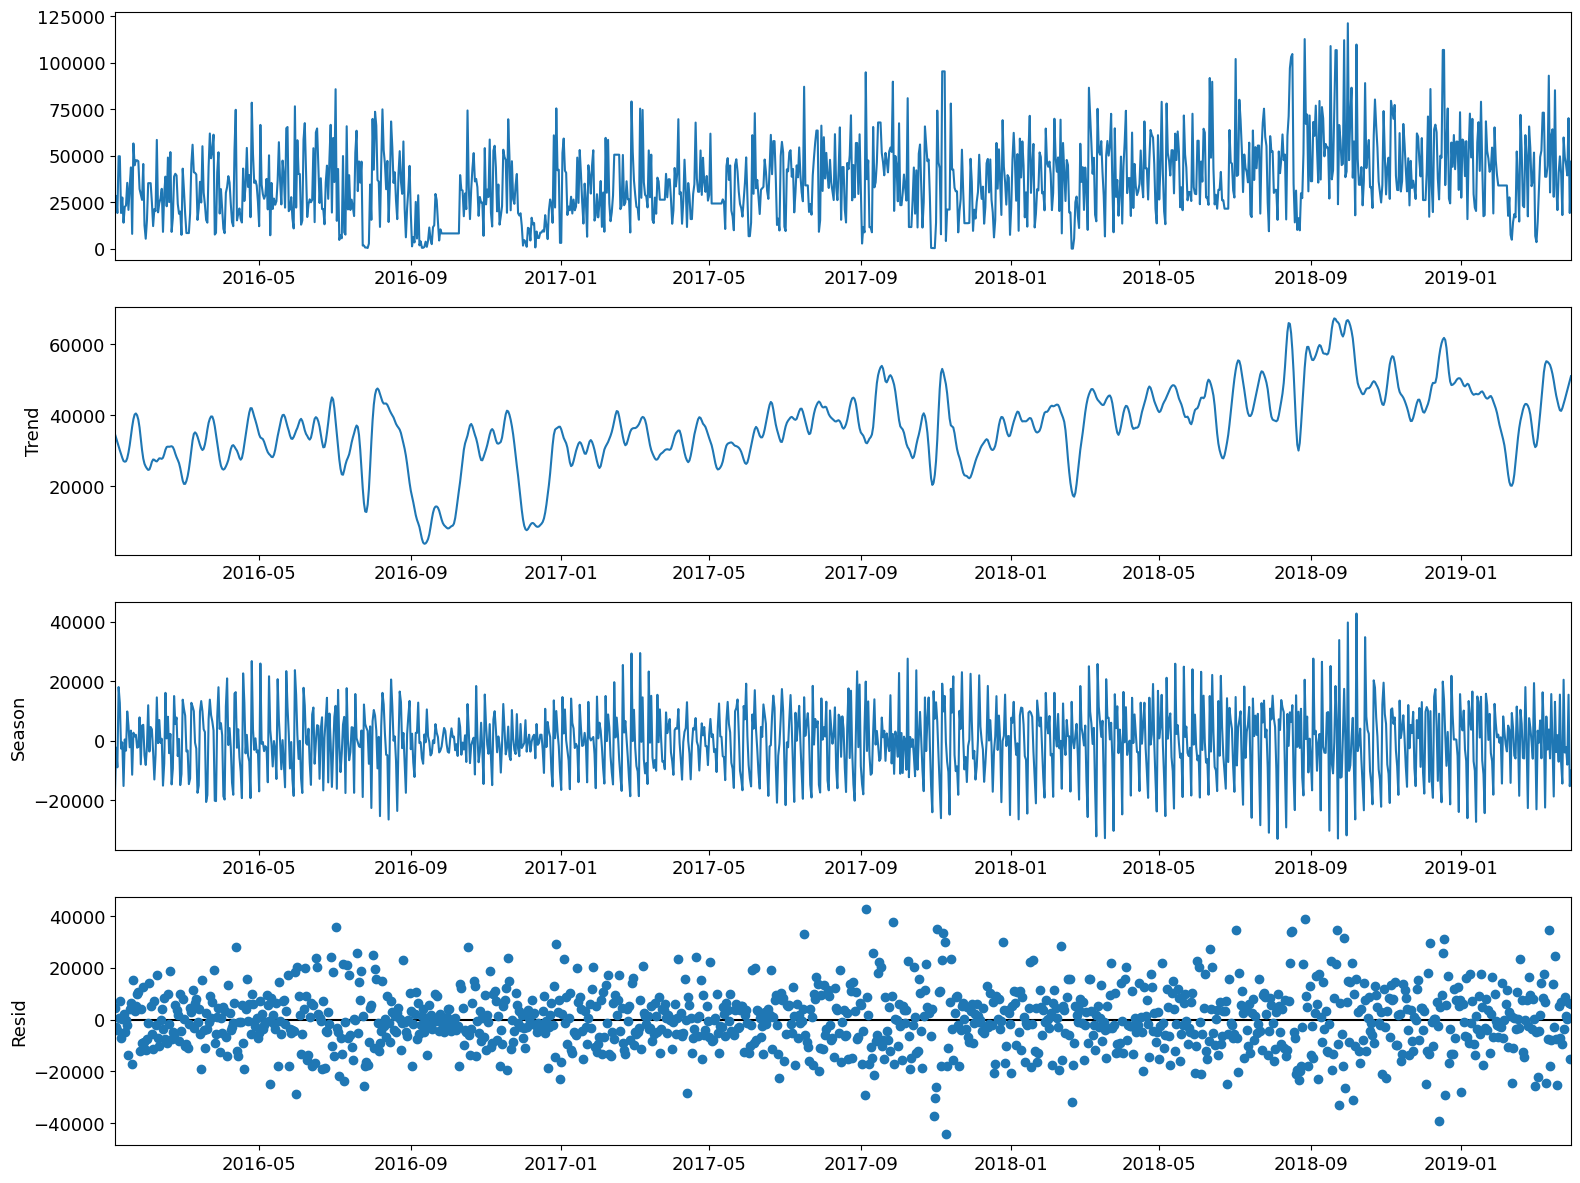

In [ ]:
from statsmodels.tsa.seasonal import STL


CashIn = pd.Series(df['CashIn'].values, index=df['timestamp'])
CashIn = CashIn.resample('D').mean().ffill() # пока заполним наны предыдущими значениями ряда, иначе ряд не декомпозируется :(

plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)
res = STL(CashIn,seasonal=7).fit()
fig = res.plot()

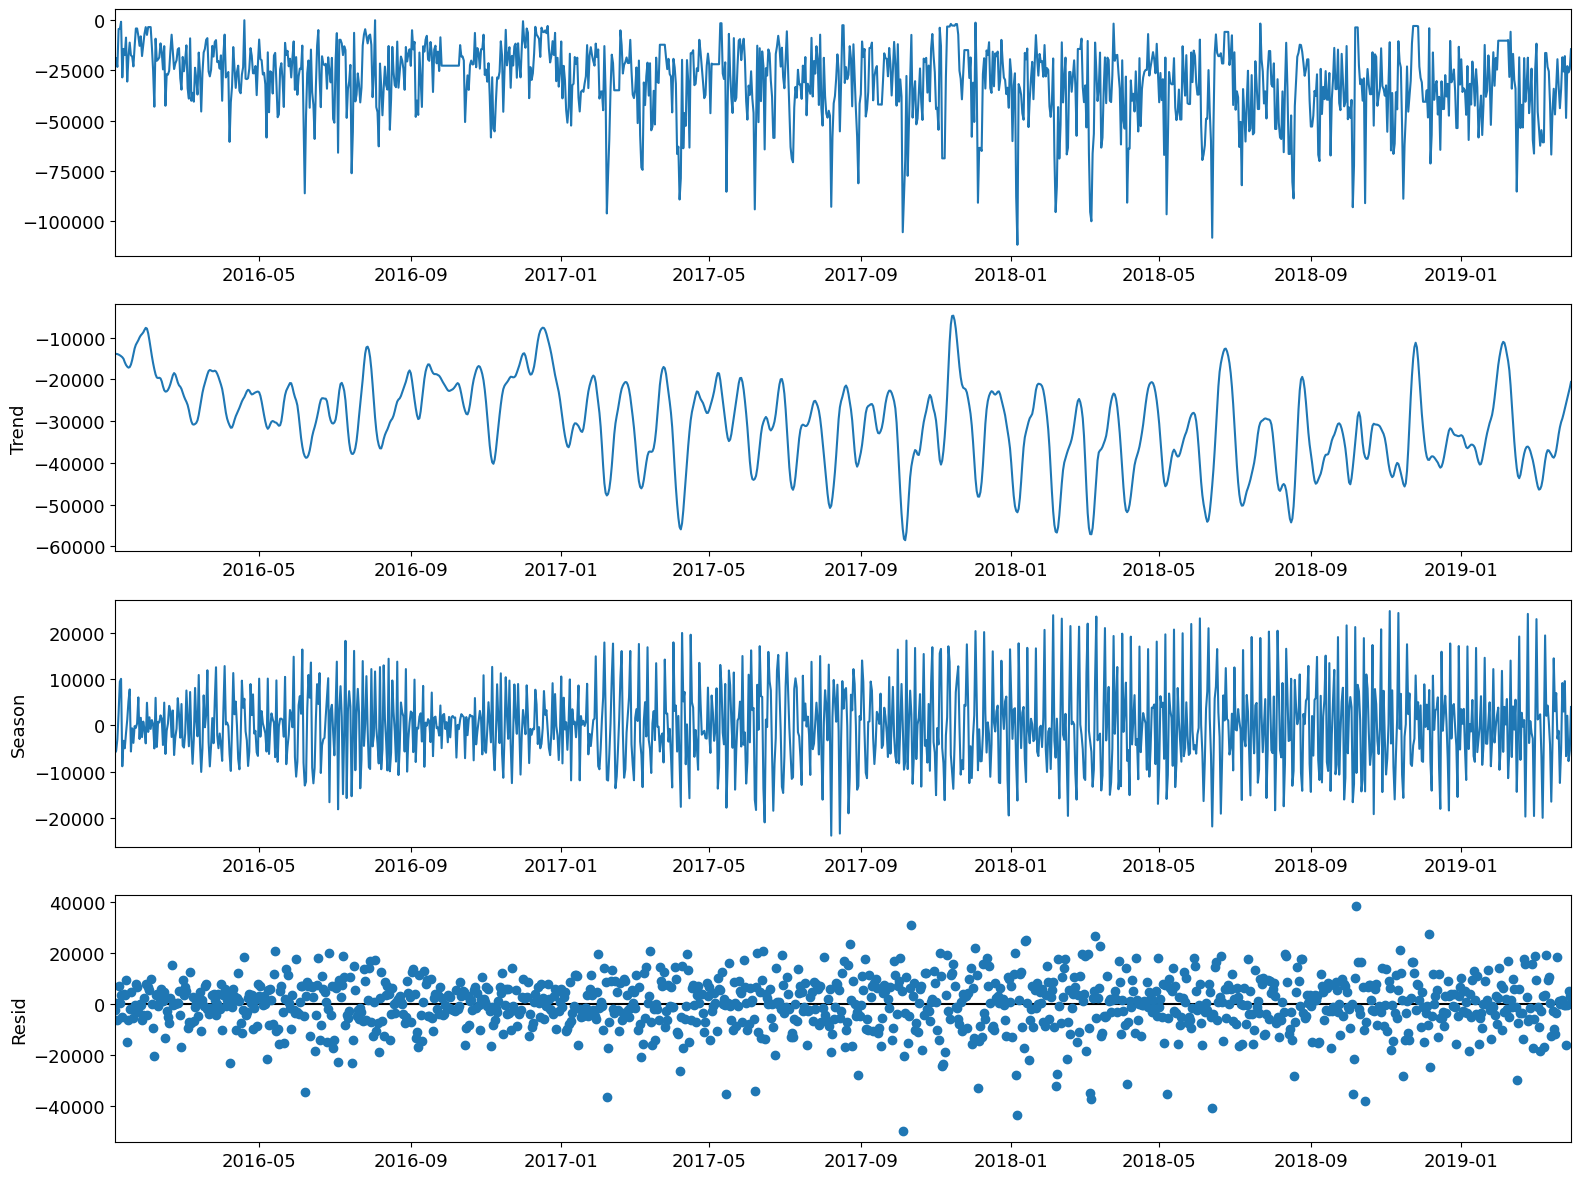

In [ ]:
CashOut = pd.Series(df['CashOut'].values, index=df['timestamp'])
CashOut = CashOut.resample('D').mean().ffill() # пока заполним наны предыдущими значениями ряда, иначе ряд не декомпозируется :(

plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)
res = STL(CashOut,seasonal=7).fit()
fig = res.plot()

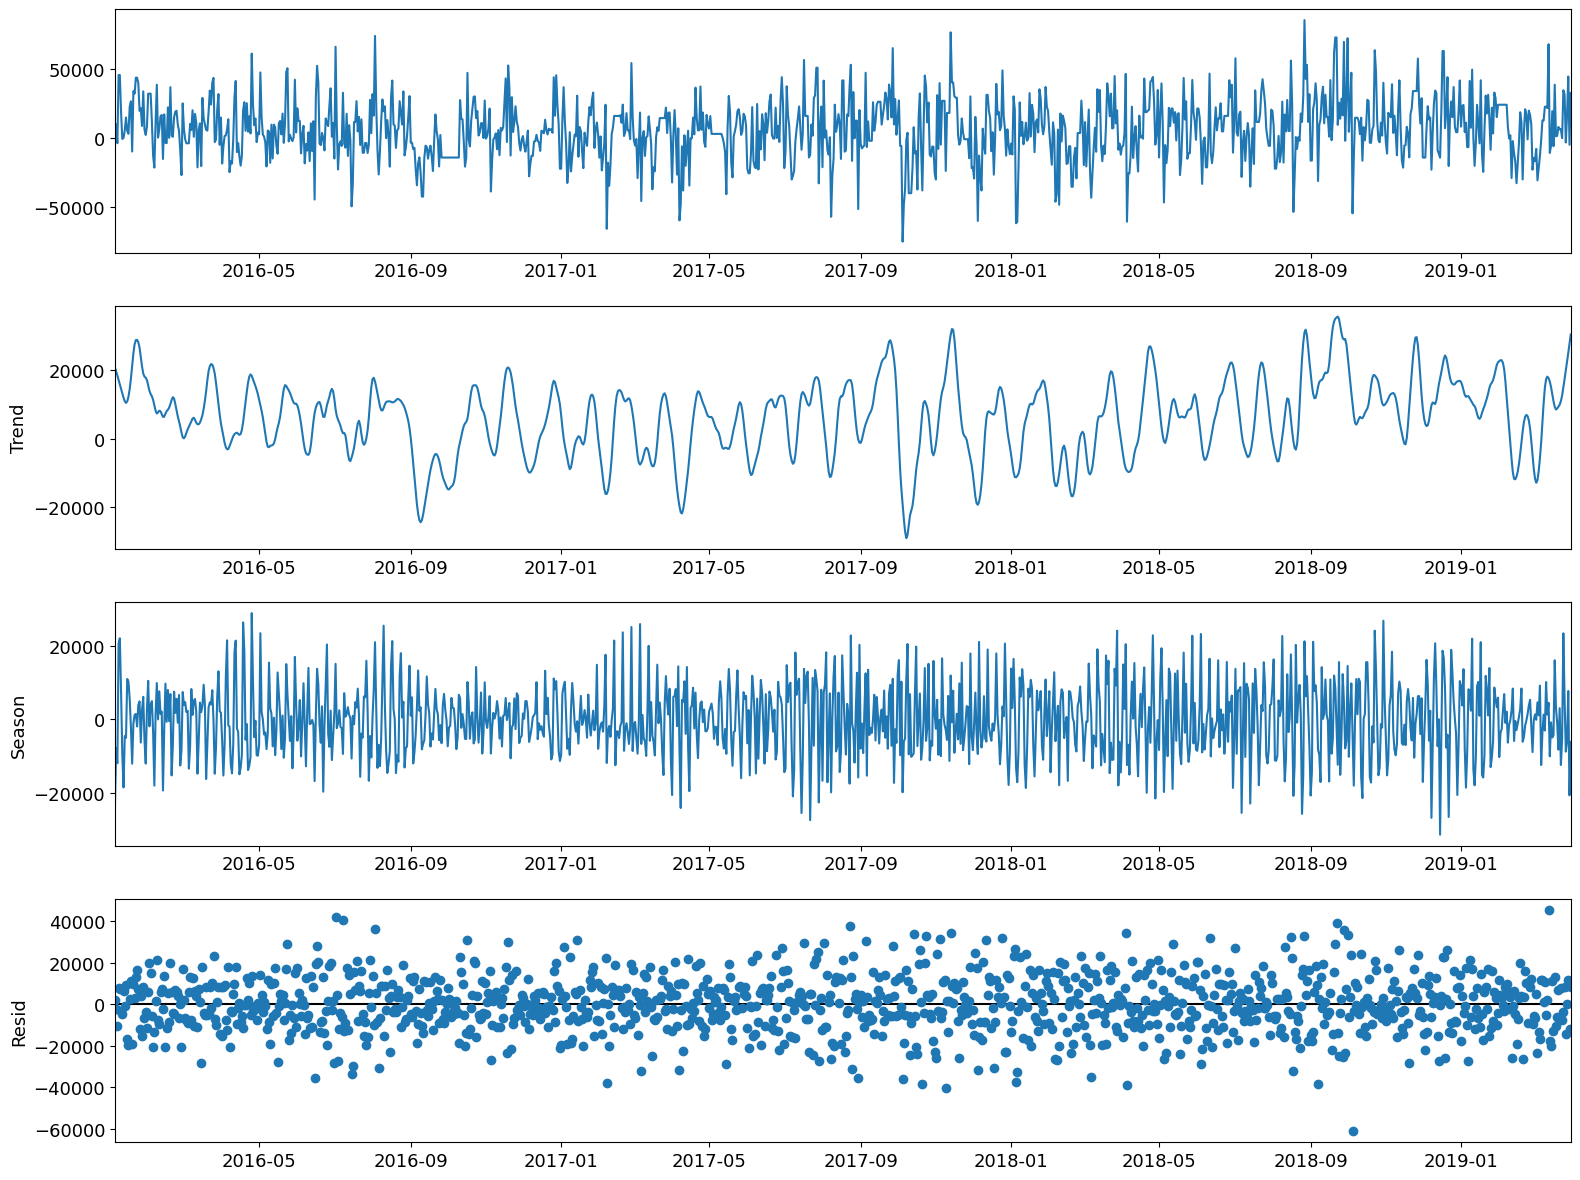

In [ ]:
target = pd.Series(df['CashNet'].values, index=df['timestamp'])
target = target.resample('D').mean().ffill() # пока заполним наны предыдущими значениями ряда, иначе ряд не декомпозируется :(

plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)
res = STL(target,seasonal=7).fit()
fig = res.plot()

Видим, что трендовая и сезонная составляющая крайне зашумлены. Характерного тренда нет, сезонность имеет сложный характер. Остатки колюблются возле 0, однако о неком постоянстве дисперсии можно говорять только в ряде CashNet.

### Задание 2. Приведение в формат multi-segment (0.75 балла)

Теперь нам предстоит (в первый раз) привести данные к формату, в котором с ними будет возможно работать средствами ETNA. Вначале мы будем рассматривать и предсказывать наши данные как мульти-сегментные. Чтобы привести данные в соответствующий формат, вам пригодится функция `pd.melt`. На выходе у нас должен получиться объект `TSDataset`. Поскольку мы будем смотреть на данные не только в этом разрезе, лучше не менять исходный датафрейм и работать с копией.

In [ ]:
from etna.datasets import TSDataset

In [ ]:
df_ts = df.copy(deep = True)
df_ts = pd.melt(df_ts, id_vars=['timestamp'])
df_ts['segment'] = df_ts['variable']
df_ts['target'] = df_ts['value']
df_ts.drop(columns=["variable", "value"], inplace=True)
df_ts.head()

timestamp segment   target
0 2016-01-05  CashIn  20840.0
1 2016-01-06  CashIn  28460.0
2 2016-01-07  CashIn  19250.0
3 2016-01-08  CashIn  49770.0
4 2016-01-09  CashIn      NaN

In [ ]:
df_ts = TSDataset.to_dataset(df_ts)
ts = TSDataset(df_ts, freq="D")
ts.head()

segment      CashIn  CashNet  CashOut
feature      target   target   target
timestamp                            
2016-01-05  20840.0  -1360.0 -22200.0
2016-01-06  28460.0   9650.0 -18810.0
2016-01-07  19250.0  -3960.0 -23210.0
2016-01-08  49770.0  45420.0  -4350.0
2016-01-09      NaN      NaN      NaN

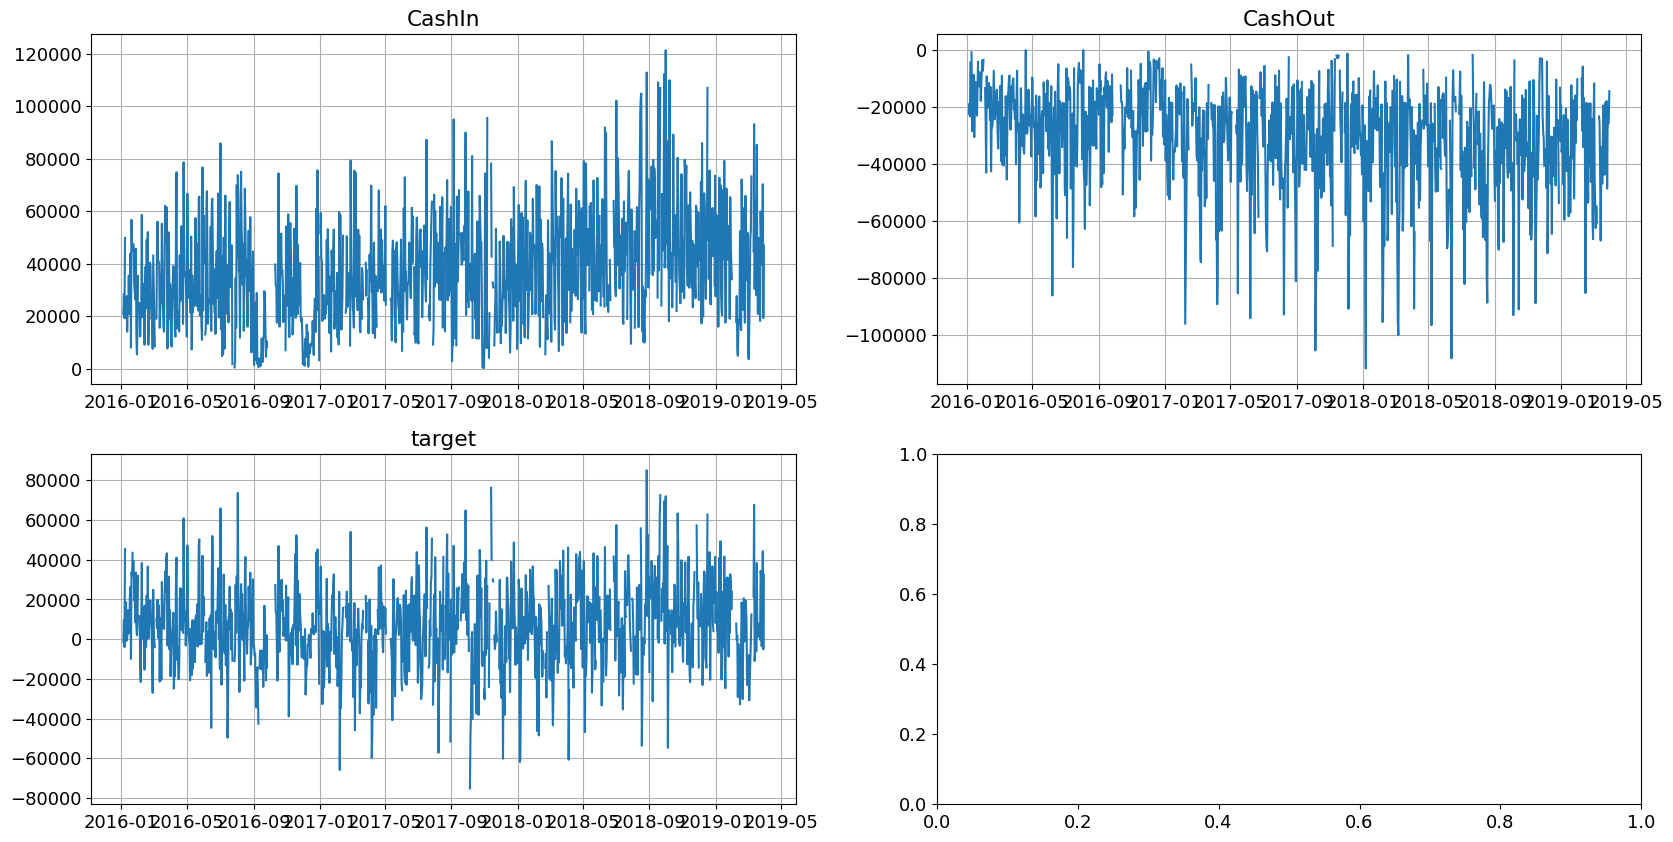

In [ ]:
ts.plot()

### Задание 3. Работа с пропущенными значениями и аутлаерами (1 балл)

Проанализируйте, есть ли в данных пропущенные значения, и подберите оптимальный метод их заполнения средствами ETNA. Какие методы вы выберете и почему? Совет: возможно, лучше сохранить заполненные данные в отдельный объект, поскольку некоторые модели заполняют пропуски встроенными методами, и подача на вход "сырых" данных (на языке временных рядов это данные с нерегулярными интервалами) может принести лучший результат.

Импорты всех необходимых компонент произведите самостоятельно.

Перейдем к заполнению пропущенных значений. Чтобы избежать "подглядывания" в тестовую выборку, поделим ряды на трейн и тест и с учетом выбранной стратегии заполнения пропусков сделаем fit_transform на тренировочной и transform на тестовой выборке. 

1. Стратегия заполнения средним по трейновой выборке.

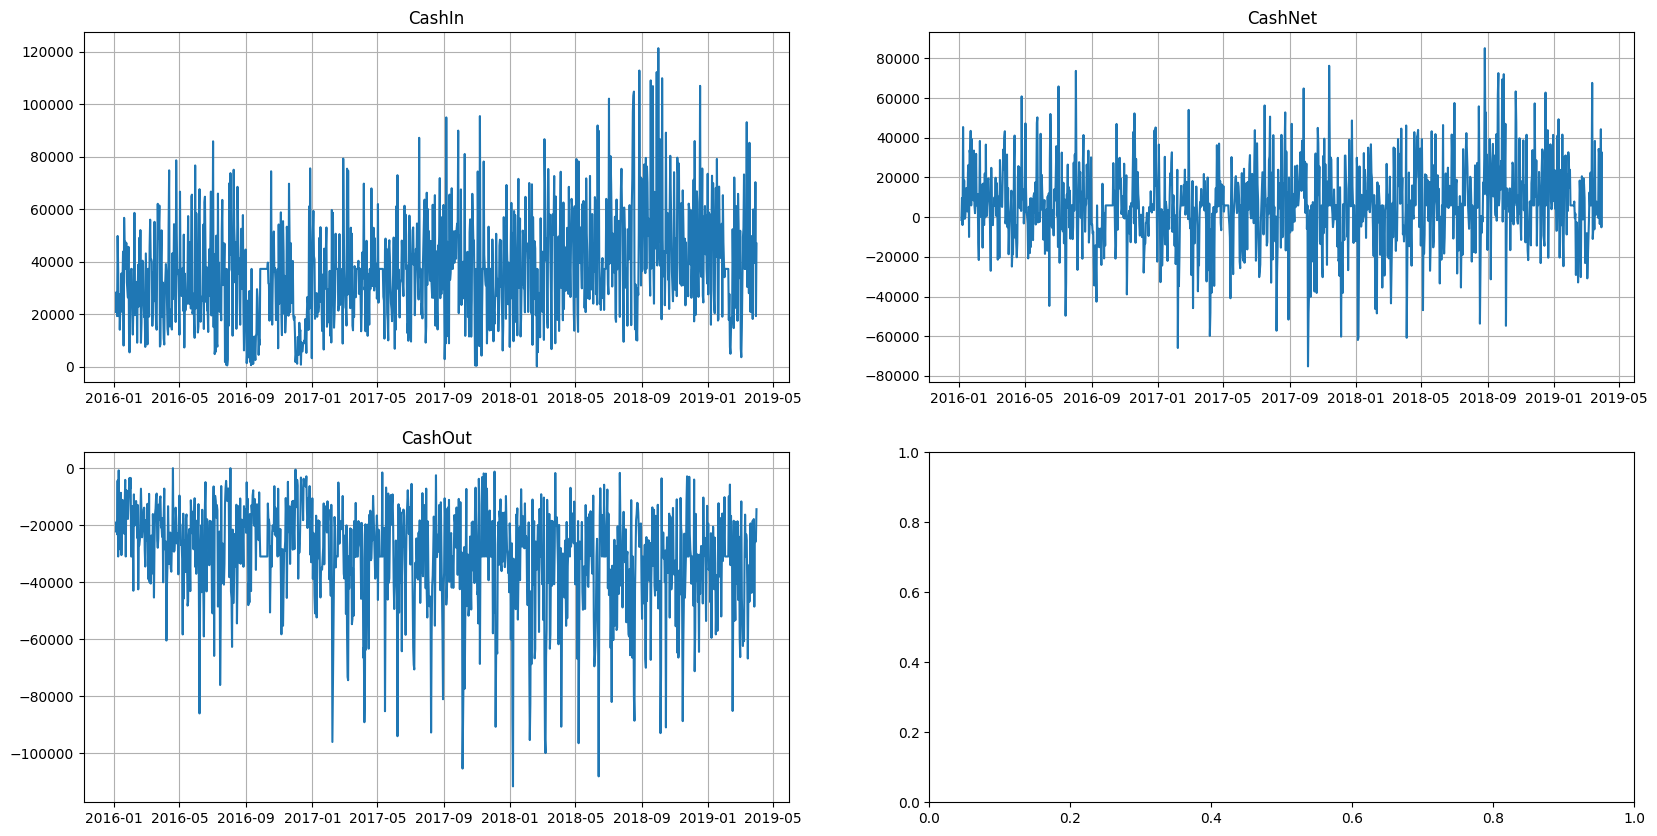

In [ ]:
nan_imputer = TimeSeriesImputerTransform(
    in_column="target", strategy="mean")

train_ts, test_ts = ts.train_test_split(
    train_start="2016-01-05",
    train_end="2019-03-26",
    test_start="2019-03-27",
    test_end="2019-03-31",
)
train_ts.fit_transform([nan_imputer])
test_ts.transform([nan_imputer])
train = train_ts.to_pandas(True) # пришлось возвращаться к pandas dataframe, потому что ts трейн и тест не склеивались
test = test_ts.to_pandas(True)
data = pd.concat([train.iloc[:int(len(train)/3),], test.iloc[:int(len(test)/3),], train.iloc[int(len(train)/3) : 2*int(len(train)/3)], 
                  test.iloc[int(len(test)/3) : 2*int(len(test)/3),], train.iloc[2*int(len(train)/3):], test.iloc[2*int(len(test)/3):]], axis=0).reset_index(drop=True)

df_ts2 = TSDataset.to_dataset(data)
ts2 = TSDataset(df_ts2, freq="D") 
ts2.plot()

Заметим, что пропуски заполнились "константным" значением – средним по всей тренировочной выборке, что нереалистично (в случае, когда имеется интервал пропущенных значений). Также не учитывается последняя динамика ряда (то есть динамику последних доступных данных до пропусков).

2. Стратегия заполнения последним доступным значением.

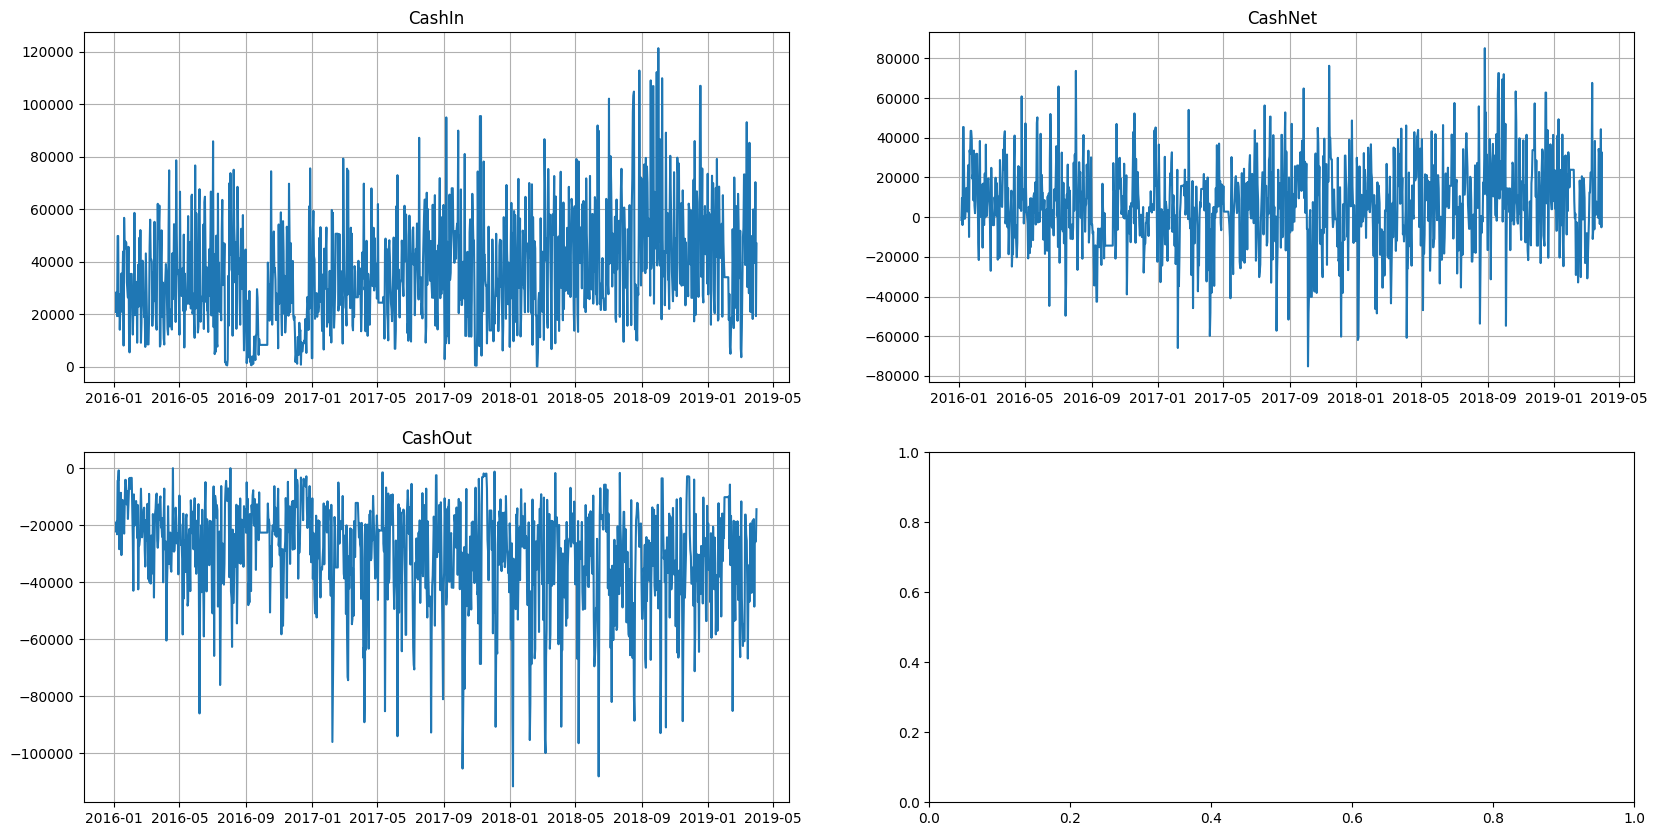

In [ ]:
nan_imputer = TimeSeriesImputerTransform(
    in_column="target", strategy="forward_fill")

train_ts, test_ts = ts.train_test_split(
    train_start="2016-01-05",
    train_end="2019-03-26",
    test_start="2019-03-27",
    test_end="2019-03-31",
)
train_ts.fit_transform([nan_imputer])
test_ts.transform([nan_imputer])
train = train_ts.to_pandas(True)
test = test_ts.to_pandas(True)
data = pd.concat([train.iloc[:int(len(train)/3),], test.iloc[:int(len(test)/3),], train.iloc[int(len(train)/3) : 2*int(len(train)/3)], 
                  test.iloc[int(len(test)/3) : 2*int(len(test)/3),], train.iloc[2*int(len(train)/3):], test.iloc[2*int(len(test)/3):]], axis=0).reset_index(drop=True)

df_ts2 = TSDataset.to_dataset(data)
ts2 = TSDataset(df_ts2, freq="D") 
ts2.plot()

В данном случае мы в большей степени улавливаем динамику ряда (заполняем последним доступным значением, оно более актуально для следующего дня), но проблема с интервалами сохраняется.

3. Стратегия заполнения running_mean (окно – 21).

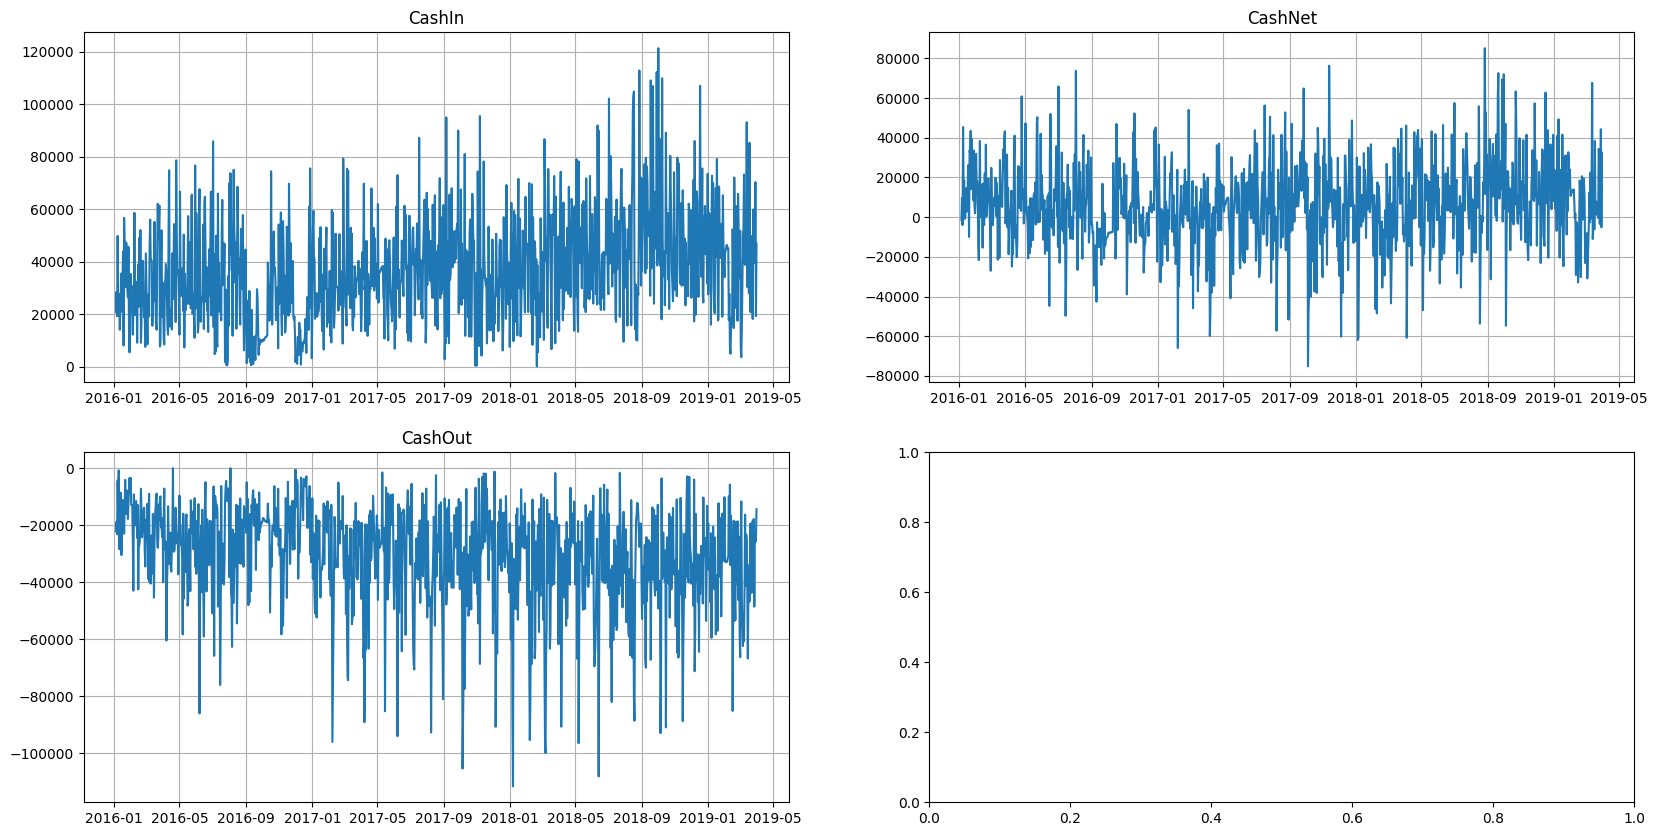

In [ ]:
nan_imputer = TimeSeriesImputerTransform(
    in_column="target", strategy="running_mean", window = 21)

train_ts, test_ts = ts.train_test_split(
    train_start="2016-01-05",
    train_end="2019-03-26",
    test_start="2019-03-27",
    test_end="2019-03-31",
)
train_ts.fit_transform([nan_imputer])
#test_ts.transform([nan_imputer]) # на тесте заполнить не может
train = train_ts.to_pandas(True)
test = test_ts.to_pandas(True)
data = pd.concat([train.iloc[:int(len(train)/3),], test.iloc[:int(len(test)/3),], train.iloc[int(len(train)/3) : 2*int(len(train)/3)], 
                  test.iloc[int(len(test)/3) : 2*int(len(test)/3),], train.iloc[2*int(len(train)/3):], test.iloc[2*int(len(test)/3):]], axis=0).reset_index(drop=True)

df_ts2 = TSDataset.to_dataset(data)
ts2 = TSDataset(df_ts2, freq="D") 
ts2.plot()

Стратегия running_mean оказалась значительно лучше, так как усреднения по "бегущему окну" позволило сохранить динамику ряда даже на интервалах пропущенных значений. Будем придерживаться данного способа заполнения пропусков далее.

Проверьте ряды на наличие аутлаеров, и очистите их соответствующим образом. Обоснуйте выбор.

1. Отклонение от медианных значений, рассчитанных по окну

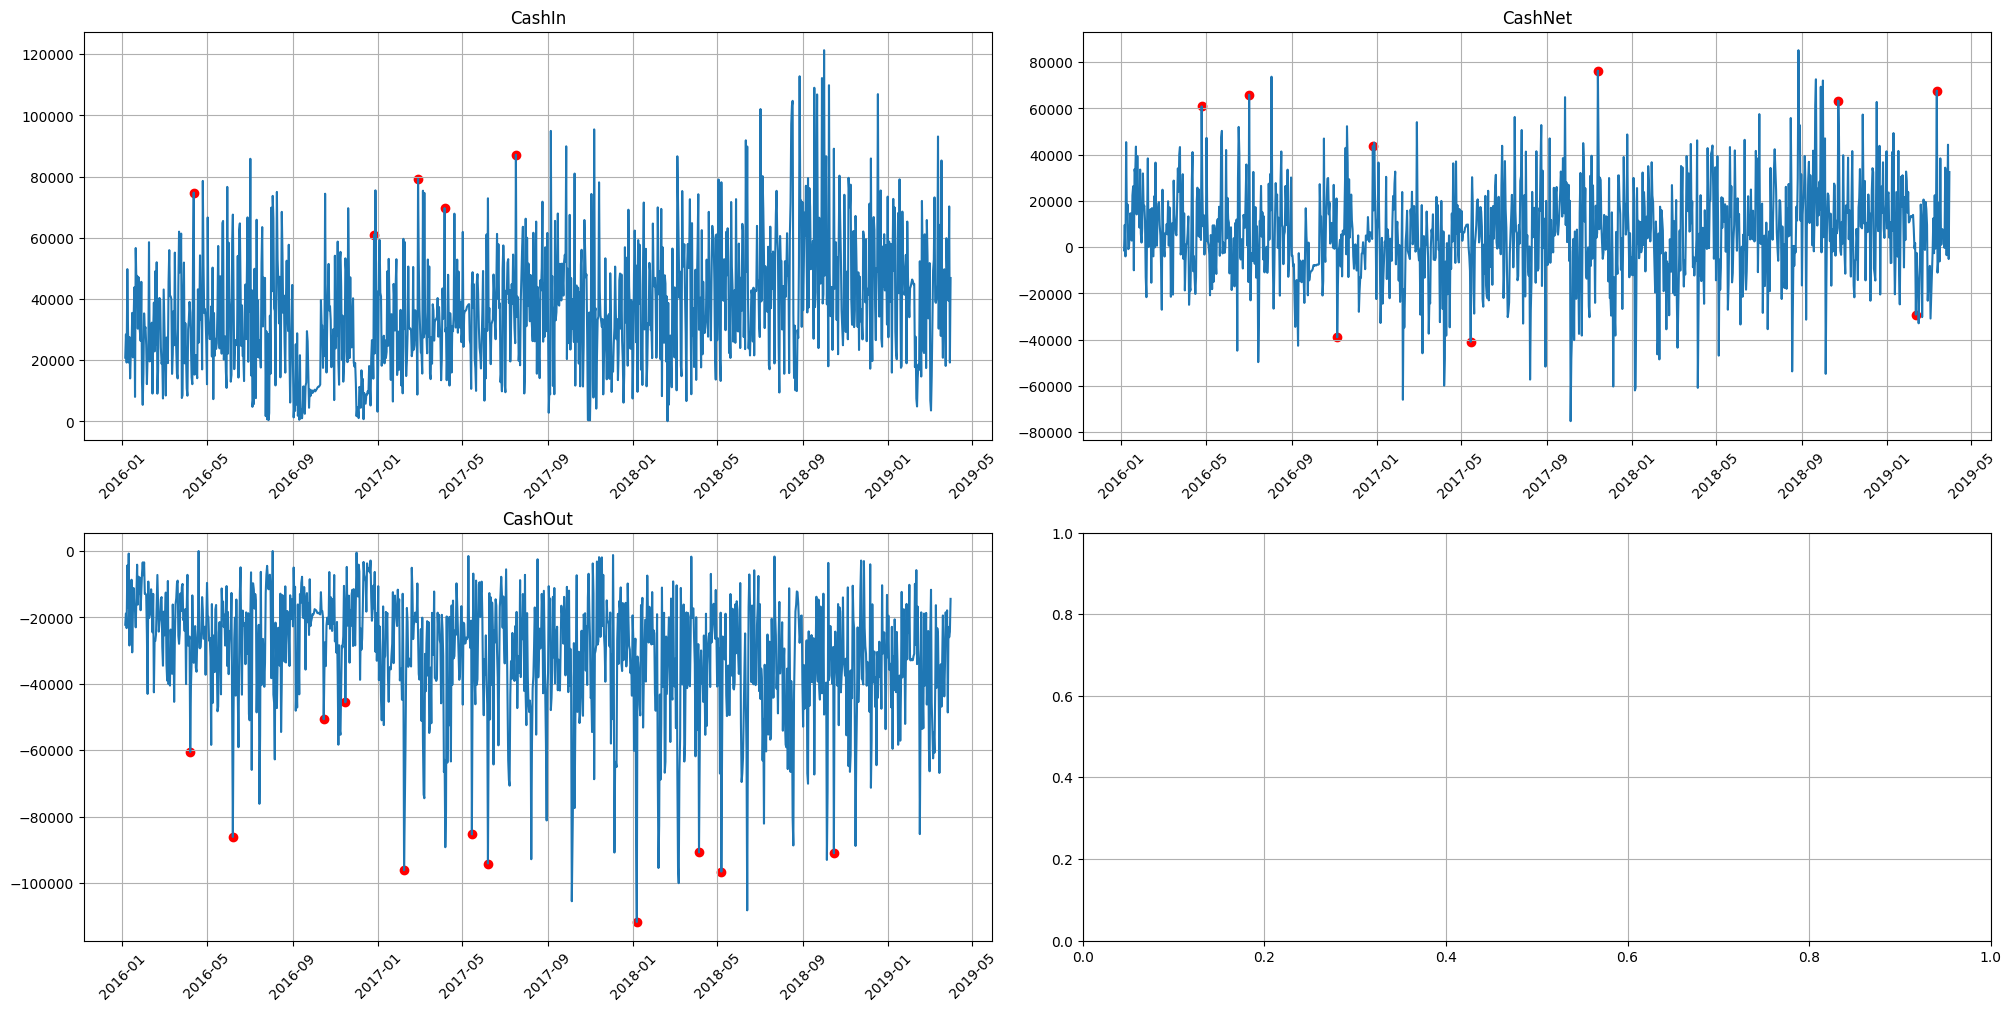

In [ ]:
anomaly_dict = get_anomalies_median(ts2, window_size=21) 
plot_anomalies(ts2, anomaly_dict)

2. Метод на основе плотности точек (density-based)

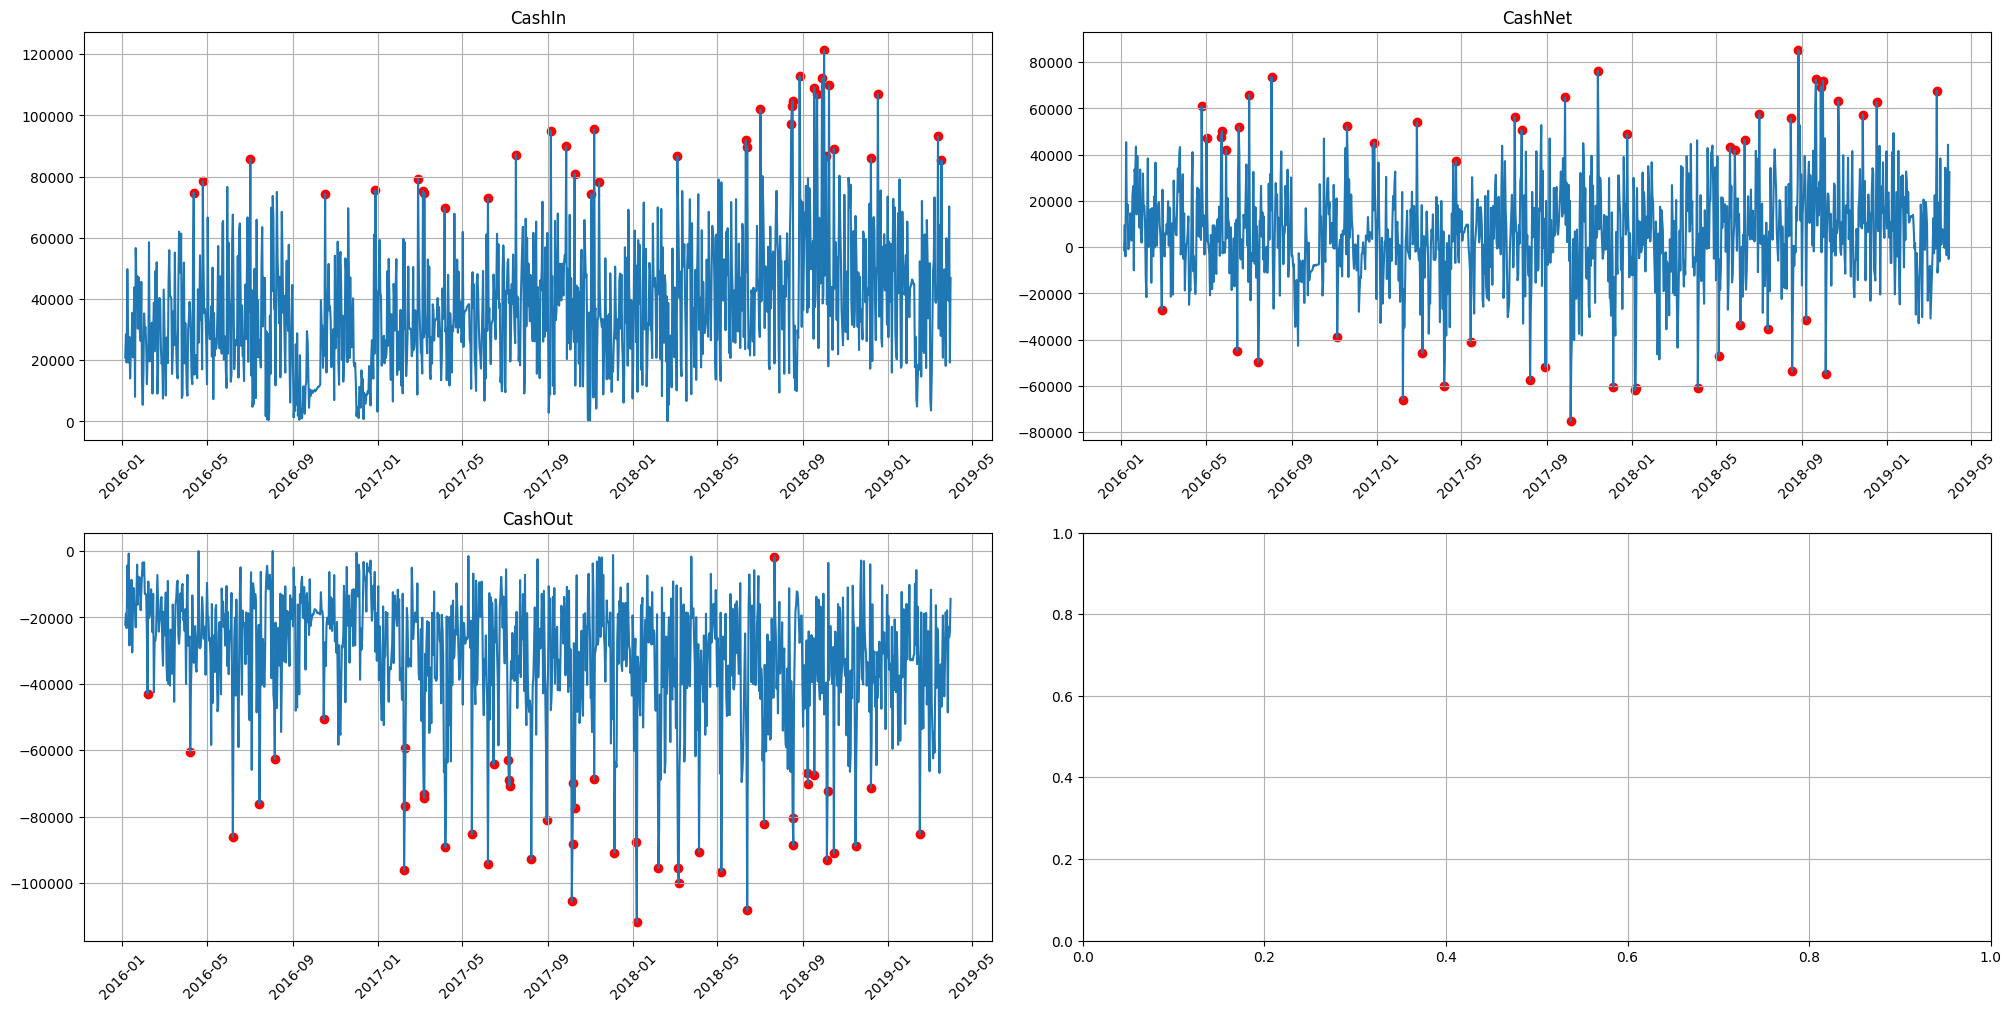

In [ ]:
anomaly_dict = get_anomalies_density(ts2, window_size=21, distance_coef=1, n_neighbors=4)
plot_anomalies(ts2, anomaly_dict)

3. Метод на основе предсказаний модели

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpewh534n8/9o_038xc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpewh534n8/oikrofvn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2616', 'data', 'file=/tmp/tmpewh534n8/9o_038xc.json', 'init=/tmp/tmpewh534n8/oikrofvn.json', 'output', 'file=/tmp/tmpjteeuelx/prophet_model-20230514090640.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:06:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:06:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpewh534n8/qcuu8y4d.json
DE

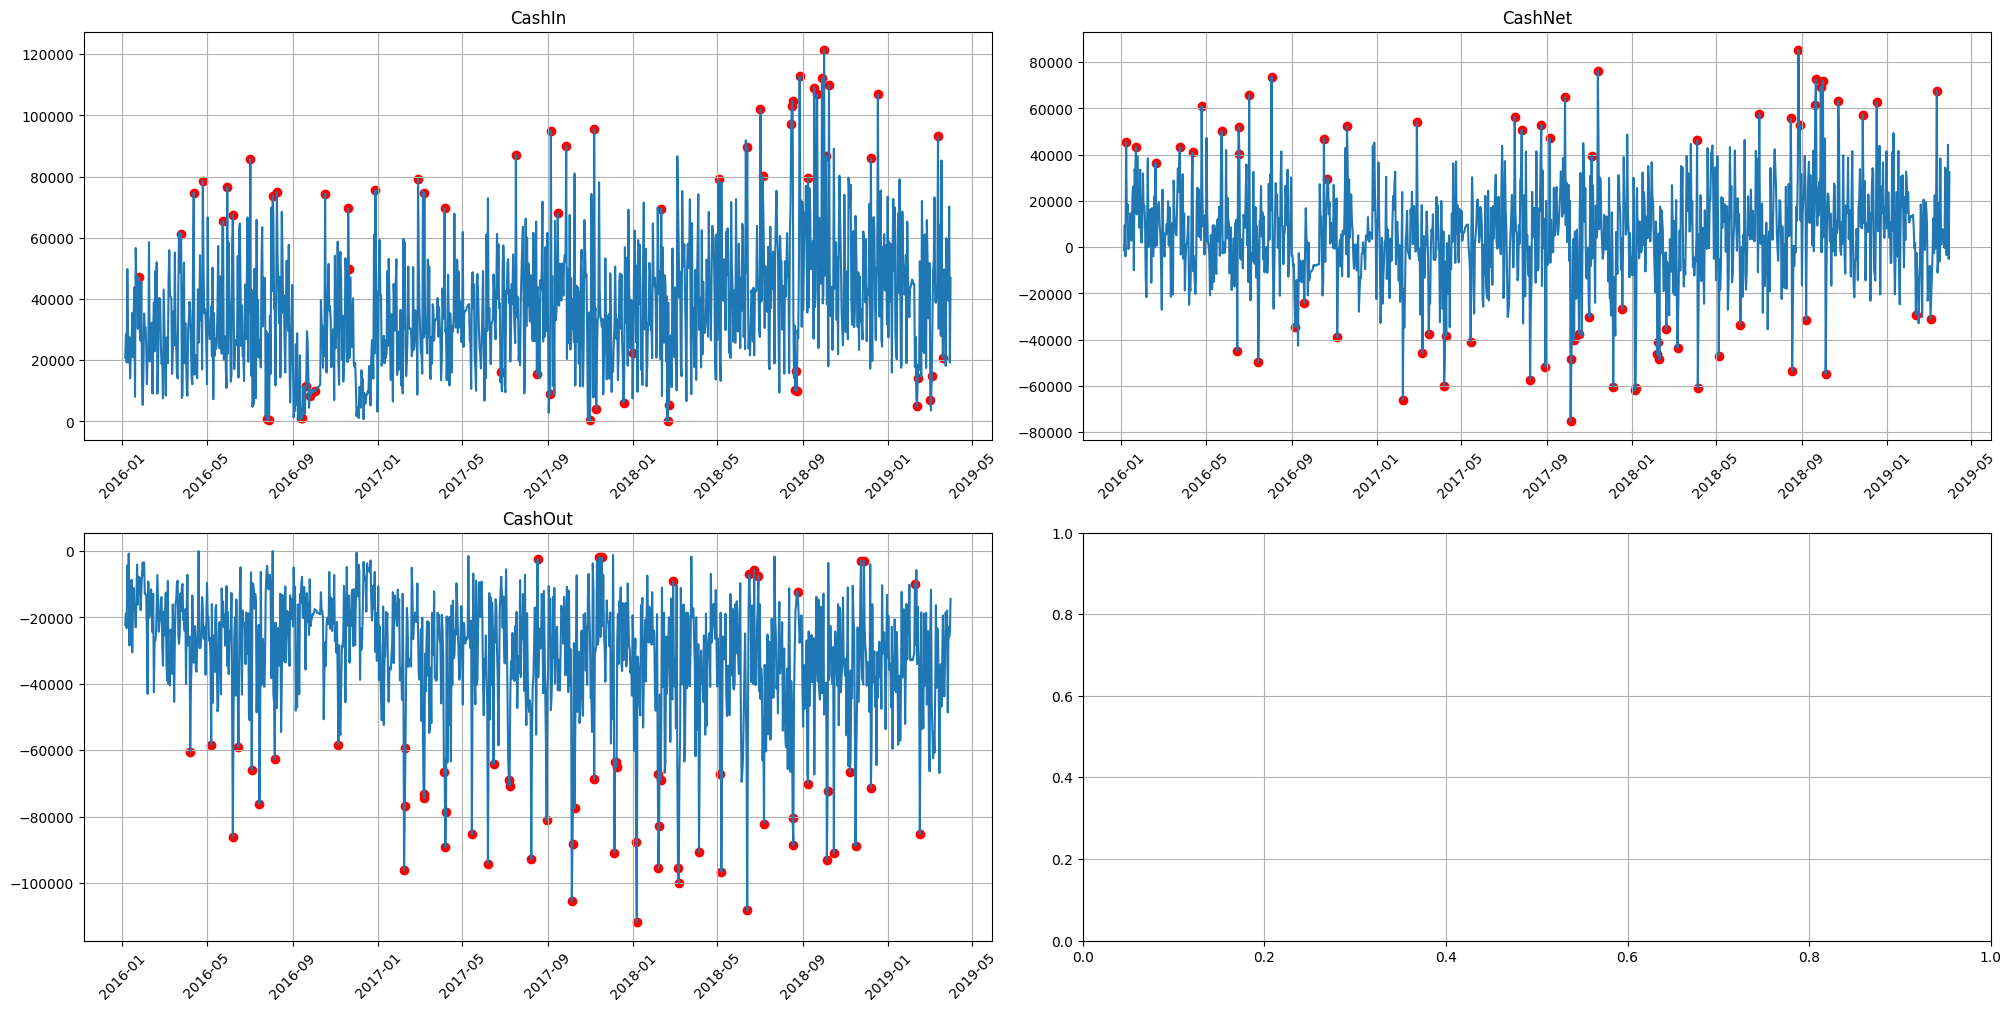

In [ ]:
anomaly_dict = get_anomalies_prediction_interval(
    ts2, model=ProphetModel, interval_width=0.95
)

plot_anomalies(ts2, anomaly_dict)

Визуально метод на основе плотности точек оказался наилучшим, так как удалось идентифицировать нетипичные наблюдения как выбросы, но при этом сохранить те, которые важно учесть с точки зрения модели (Median – слишком мало выбросов, Prophet – слишком много).

In [ ]:
# Impute outliers with NaNs
outliers_remover = DensityOutliersTransform(in_column="target", window_size = 21, distance_coef = 1, n_neighbors = 4)
# Impute NaNs using the specified strategy 
outliers_imputer = TimeSeriesImputerTransform(
    in_column="target", strategy="running_mean", window = 21
)

### Задание 4. Построение мультисегментной модели (1.25 балла)

Постройте мульти-сегментную модель на основе Prophet, и оцените качество по SMAPE на кросс-валидации. В качестве горизонта предсказания возьмите 5 дней - этого же горизонта будем придерживаться и в дальнейшем.

Отрисуйте получившийся прогноз.

In [ ]:
from etna.pipeline import Pipeline
from etna.models import ProphetModel
from etna.metrics import SMAPE, MAE
from etna.analysis import plot_backtest

In [ ]:
HORIZON = 5

In [ ]:
horizon = HORIZON  
model = ProphetModel()  
transforms = [outliers_remover, outliers_imputer]
pipeline = Pipeline(model=model, transforms=transforms, horizon=horizon)

metrics, forecast, fold_info = pipeline.backtest(
    ts=ts2, metrics=[SMAPE()], aggregate_metrics=True, n_folds = 3
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpewh534n8/hcgw2mn0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpewh534n8/vvmby9zi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33045', 'data', 'file=/tmp/tmpewh534n8/hcgw2mn0.json', 'init=/tmp/tmpewh534n8/vvmby9zi.json', 'output', 'file=/tmp/tmpnpezo6fu/prophet_model-20230514092038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:20:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:20:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True t

In [ ]:
metrics

segment       SMAPE
0   CashIn   32.790041
1  CashNet  129.549604
2  CashOut   38.840146

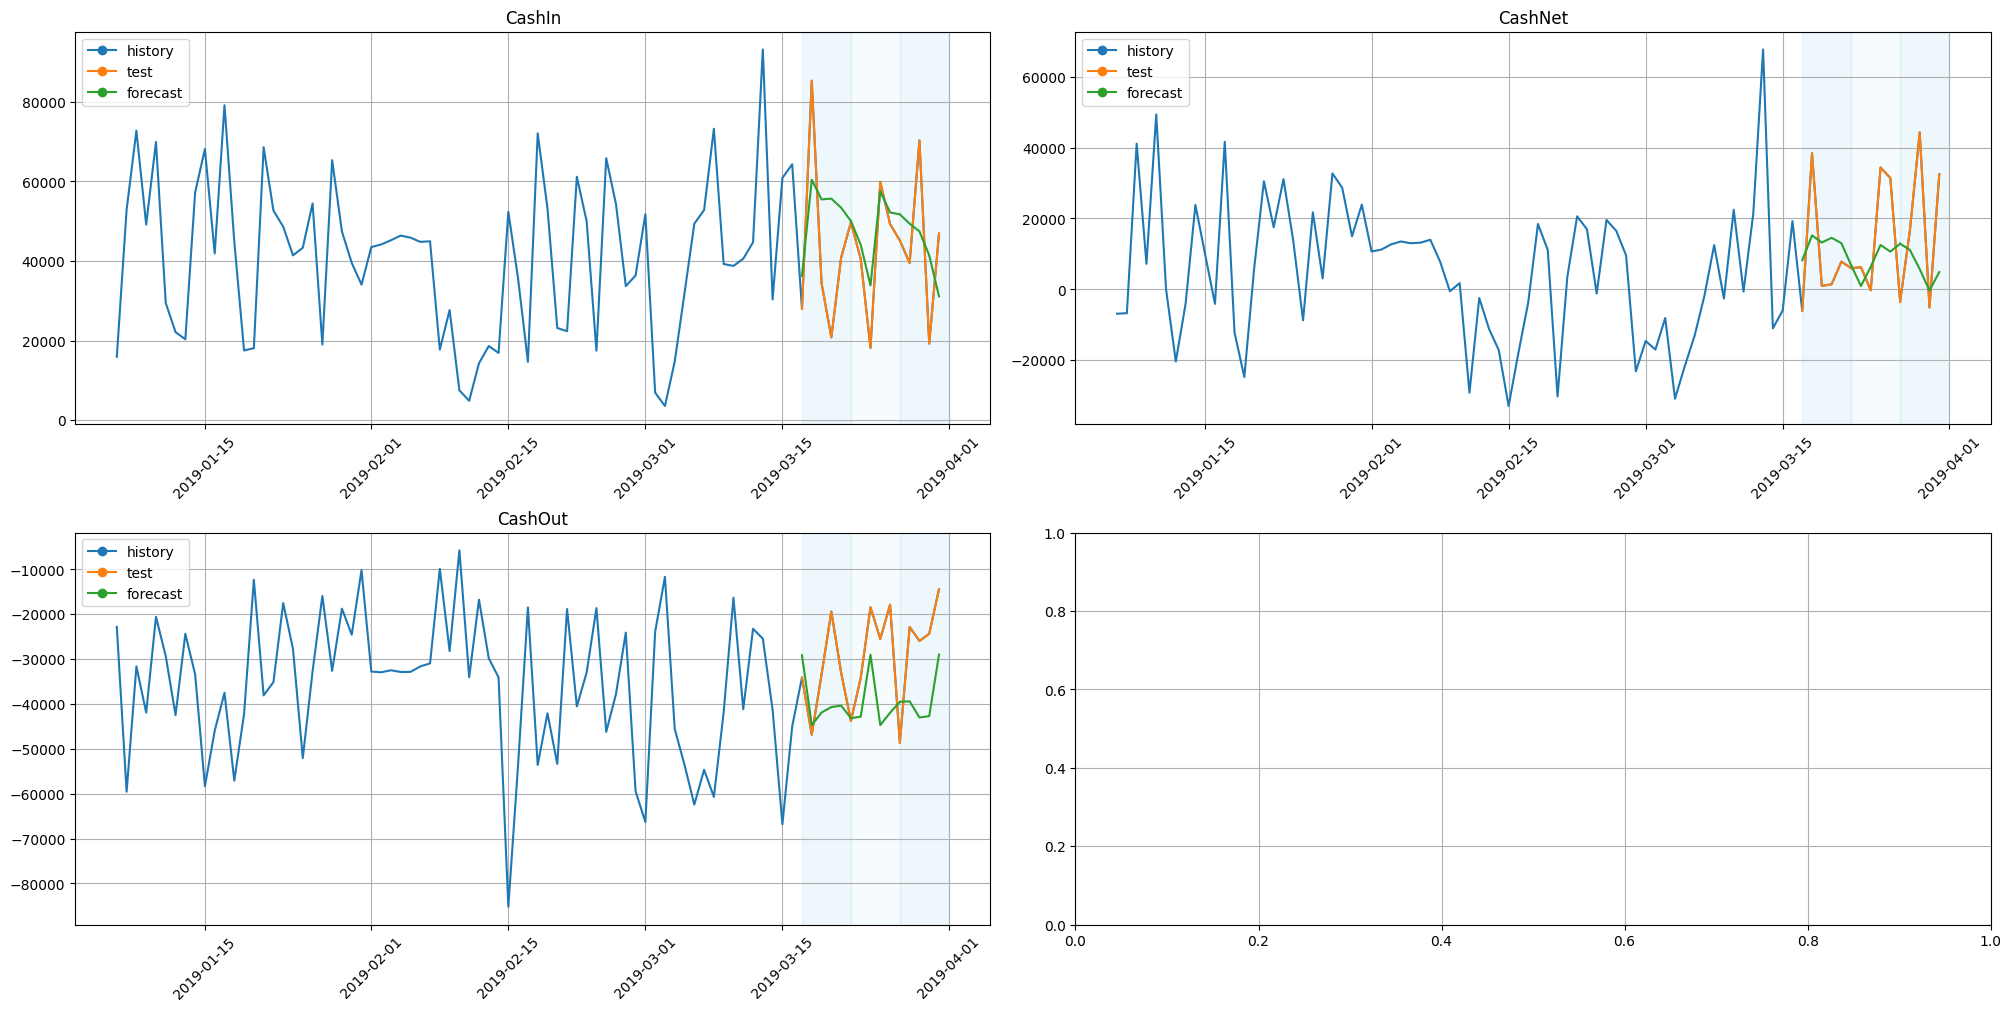

In [ ]:
plot_backtest(forecast_df=forecast, ts=ts2, history_len=70)

Исходя из статистики по каждому ряду, какой можно сделать вывод о том, как лучше предсказывать итоговое значение? Посчитайте то же самое исходя из MAE.

In [ ]:
model = ProphetModel()  
pipeline = Pipeline(model=model, transforms=transforms, horizon=horizon)  

metrics, forecast, fold_info = pipeline.backtest(
    ts=ts2, metrics=[MAE()], aggregate_metrics=True, n_folds = 3
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpewh534n8/0na3zyig.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpewh534n8/vkammf42.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2545', 'data', 'file=/tmp/tmpewh534n8/0na3zyig.json', 'init=/tmp/tmpewh534n8/vkammf42.json', 'output', 'file=/tmp/tmppvtz6t7a/prophet_model-20230514092143.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:21:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:21:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to

In [ ]:
metrics

segment           MAE
0   CashIn  13470.219970
1  CashNet  14572.560005
2  CashOut  10718.604285

Метрики для CashNet оказались самыми большими. Логично, что в предсказании CashNet стоит учитывать информацию о рядах CashIn и CashOut, из которых ряд CashNet и складывается.

### Задание 5. Иерархический временной ряд (2 балла)

Вопрос, поставленный в прошлом задании, тем не менее, естественным образом подводит нас к концепции **иерархического временного ряда** (когда один ряд состоит из других в качестве компонент). Это полезная концепция, которая может встретиться во многих задачах. В этом задании вам предстоит самостоятельно разобраться в деталях ее реализации в ETNA с использованием справочных материалов, предоставляемых библиотекой (как это часто бывает на практике). Они содержатся по следующей ссылке:

https://github.com/tinkoff-ai/etna/blob/master/examples/hierarchical_pipeline.ipynb

На выходе из первой части задания необходимо получить `TSDataset` с иерархической структурой, а также соответствующий реконсилятор, который позволит собирать искомый ряд из составных компонент. Классы, которые вам понадобятся, импортированы ниже.

In [ ]:
from etna.datasets import HierarchicalStructure
from etna.pipeline import HierarchicalPipeline
from etna.reconciliation import BottomUpReconciliator

In [ ]:
hierarchical_df = data[(data['segment'] == 'CashIn')| (data['segment'] == 'CashOut')]
new_cols = ["timestamp","target","segment"]
hierarchical_df=hierarchical_df.reindex(columns=new_cols)
hierarchical_df.head()

timestamp   target segment
0 2016-01-05  20840.0  CashIn
1 2016-01-06  28460.0  CashIn
2 2016-01-07  19250.0  CashIn
3 2016-01-08  49770.0  CashIn
4 2016-01-09  29580.0  CashIn

In [ ]:
hierarchical_df = TSDataset.to_dataset(df=hierarchical_df)

In [ ]:
hierarchical_structure = HierarchicalStructure(
    level_structure={"CashNet": ["CashIn", "CashOut"]}, level_names=["CashNet", "transactions"]
)

In [ ]:
hierarchical_ts = TSDataset(df=hierarchical_df, freq="D", hierarchical_structure=hierarchical_structure)

hierarchical_ts.head()

segment      CashIn  CashOut
feature      target   target
timestamp                   
2016-01-05  20840.0 -22200.0
2016-01-06  28460.0 -18810.0
2016-01-07  19250.0 -23210.0
2016-01-08  49770.0  -4350.0
2016-01-09  29580.0 -17142.5

In [ ]:
reconciliator = BottomUpReconciliator(target_level="CashNet", source_level="transactions")

In [ ]:
reconciliator.fit(ts=hierarchical_ts)
reconciliator.mapping_matrix.toarray()

array([[1, 1]], dtype=int32)

In [ ]:
reconciliator.aggregate(ts=hierarchical_ts).head(5)

segment      CashIn  CashOut
feature      target   target
timestamp                   
2016-01-05  20840.0 -22200.0
2016-01-06  28460.0 -18810.0
2016-01-07  19250.0 -23210.0
2016-01-08  49770.0  -4350.0
2016-01-09  29580.0 -17142.5

Во второй части задания примените найденные на предыдущих этапах преобразования очистку от аутлаеров уже к иерархическому датасету, и запустите на нем Prophet с MAE на кросс-валидации.

In [ ]:
pipeline = HierarchicalPipeline(
    transforms=[outliers_remover, outliers_imputer], horizon = horizon,
    model=ProphetModel(), reconciliator=BottomUpReconciliator(target_level="CashNet", source_level="transactions"),
)

bottom_up_metrics, forecast, _ = pipeline.backtest(ts=hierarchical_ts, metrics=[MAE()], n_folds=3, aggregate_metrics=True)
bottom_up_metrics = bottom_up_metrics.set_index("segment").add_suffix("_bottom_up")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpewh534n8/3zhu7rr6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpewh534n8/19tawafa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3125', 'data', 'file=/tmp/tmpewh534n8/3zhu7rr6.json', 'init=/tmp/tmpewh534n8/19tawafa.json', 'output', 'file=/tmp/tmpujp204h9/prophet_model-20230514092803.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:28:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:28:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to

In [ ]:
bottom_up_metrics

MAE_bottom_up
segment               
CashNet   14494.660292

### Задание 6. Построение признаков (1.5 балла)

Вернемся к нашему исходному мультисегментному ряду - теперь поработаем с моделями, которые требуют построения признаков - `ARIMA` и `CatBoost`. Построим для них признаки, и попробуем при помощи них добиться улучшения качества. Из обязательного: 1) постройте графики автокорреляции и при помощи них обоснуйте выбор лаговых признаков 2) для катбуста включите в признаки результаты STL разложения. Кроме этого, подумайте на экспертном уровне, какие закономерности могут присутствовать в пополнени наличности из банкомата? Снятии? Что из этого кажется более предсказуемым, и почему? Cделайте соответствующие признаки, и снабдите их кратким комментарием.

После этого, обучите на получившихся признаках модели.

Ниже приведены импорты, которые вам точно понадобятся - к ним необходимо добавить те инструменты, которые вы дополнительно решите использовать в анализе.

In [ ]:
from etna.analysis import sample_acf_plot, sample_pacf_plot, stl_plot
from etna.ensembles import DirectEnsemble, StackingEnsemble, VotingEnsemble
from etna.models import (CatBoostMultiSegmentModel, CatBoostModelPerSegment,
                         AutoARIMAModel)
from etna.transforms import STLTransform, LagTransform, SegmentEncoderTransform

ACF, PACF

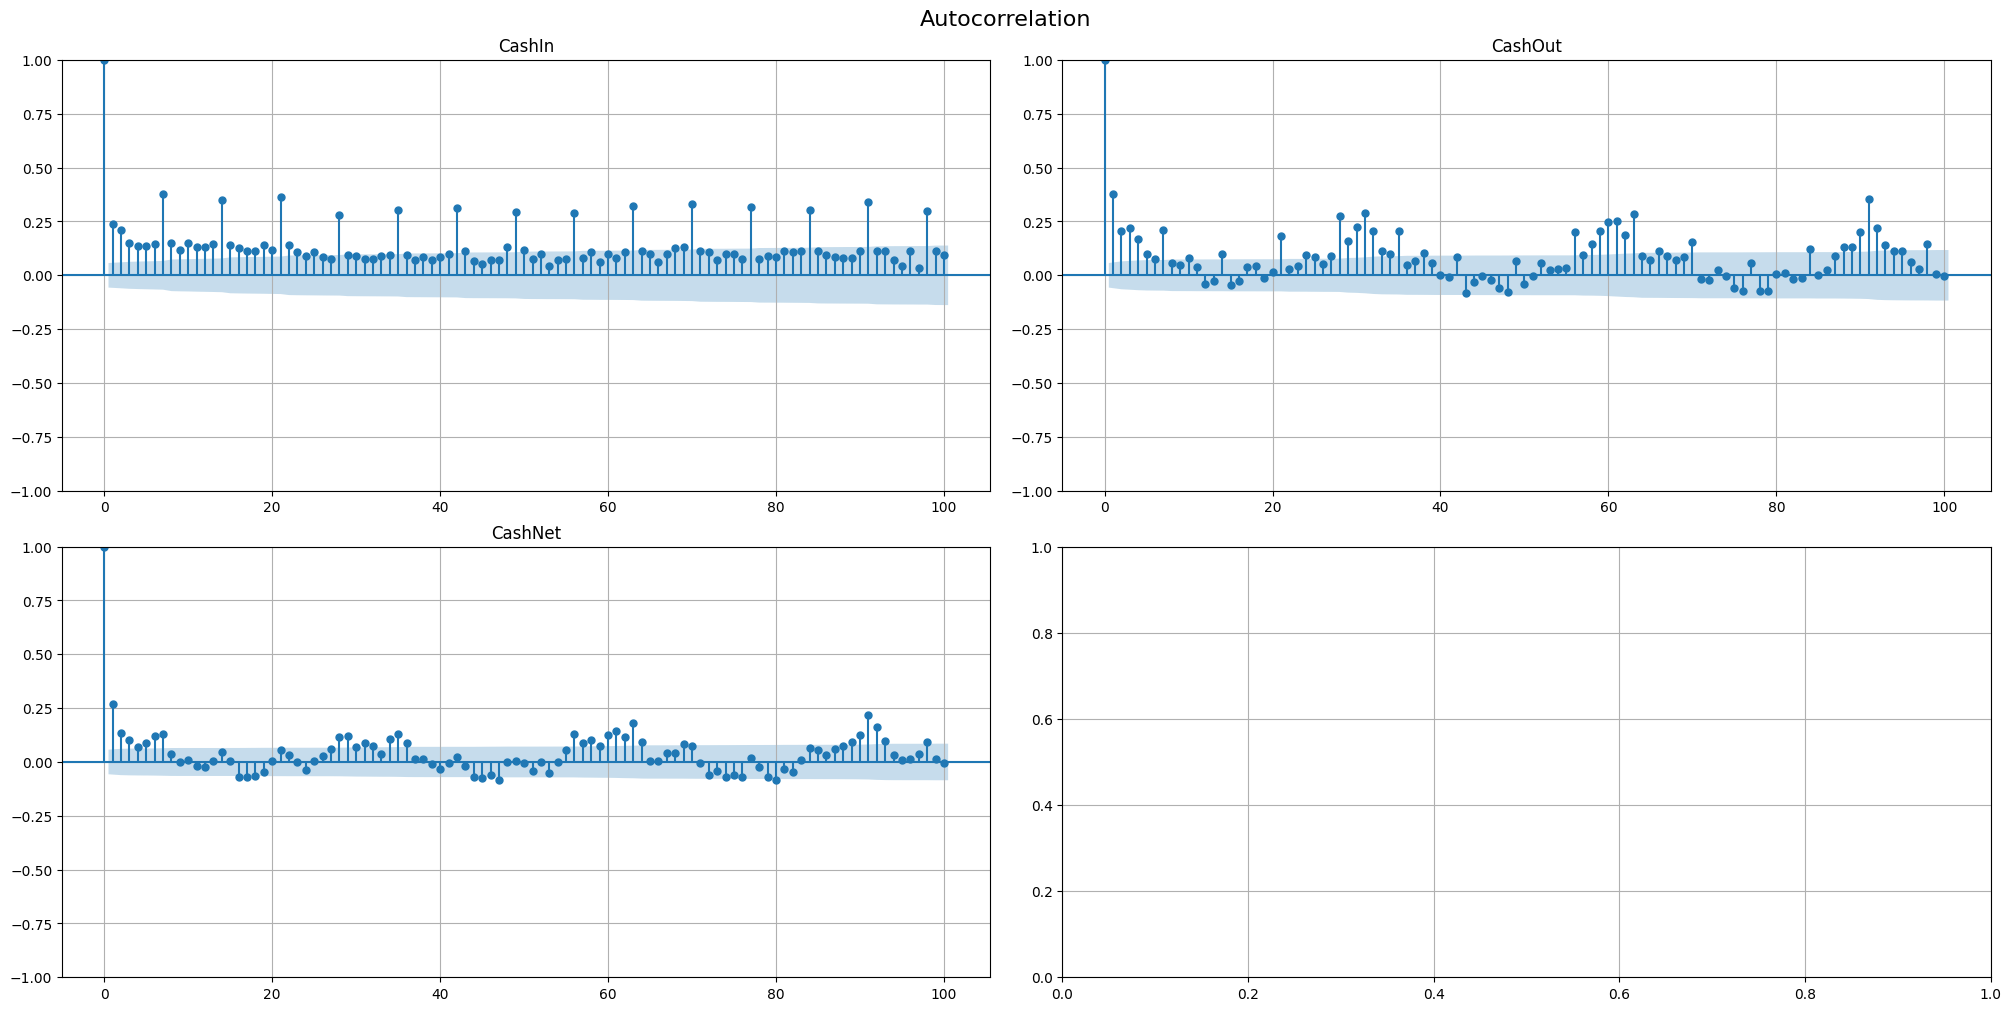

In [ ]:
sample_acf_plot(train_ts, lags=100)

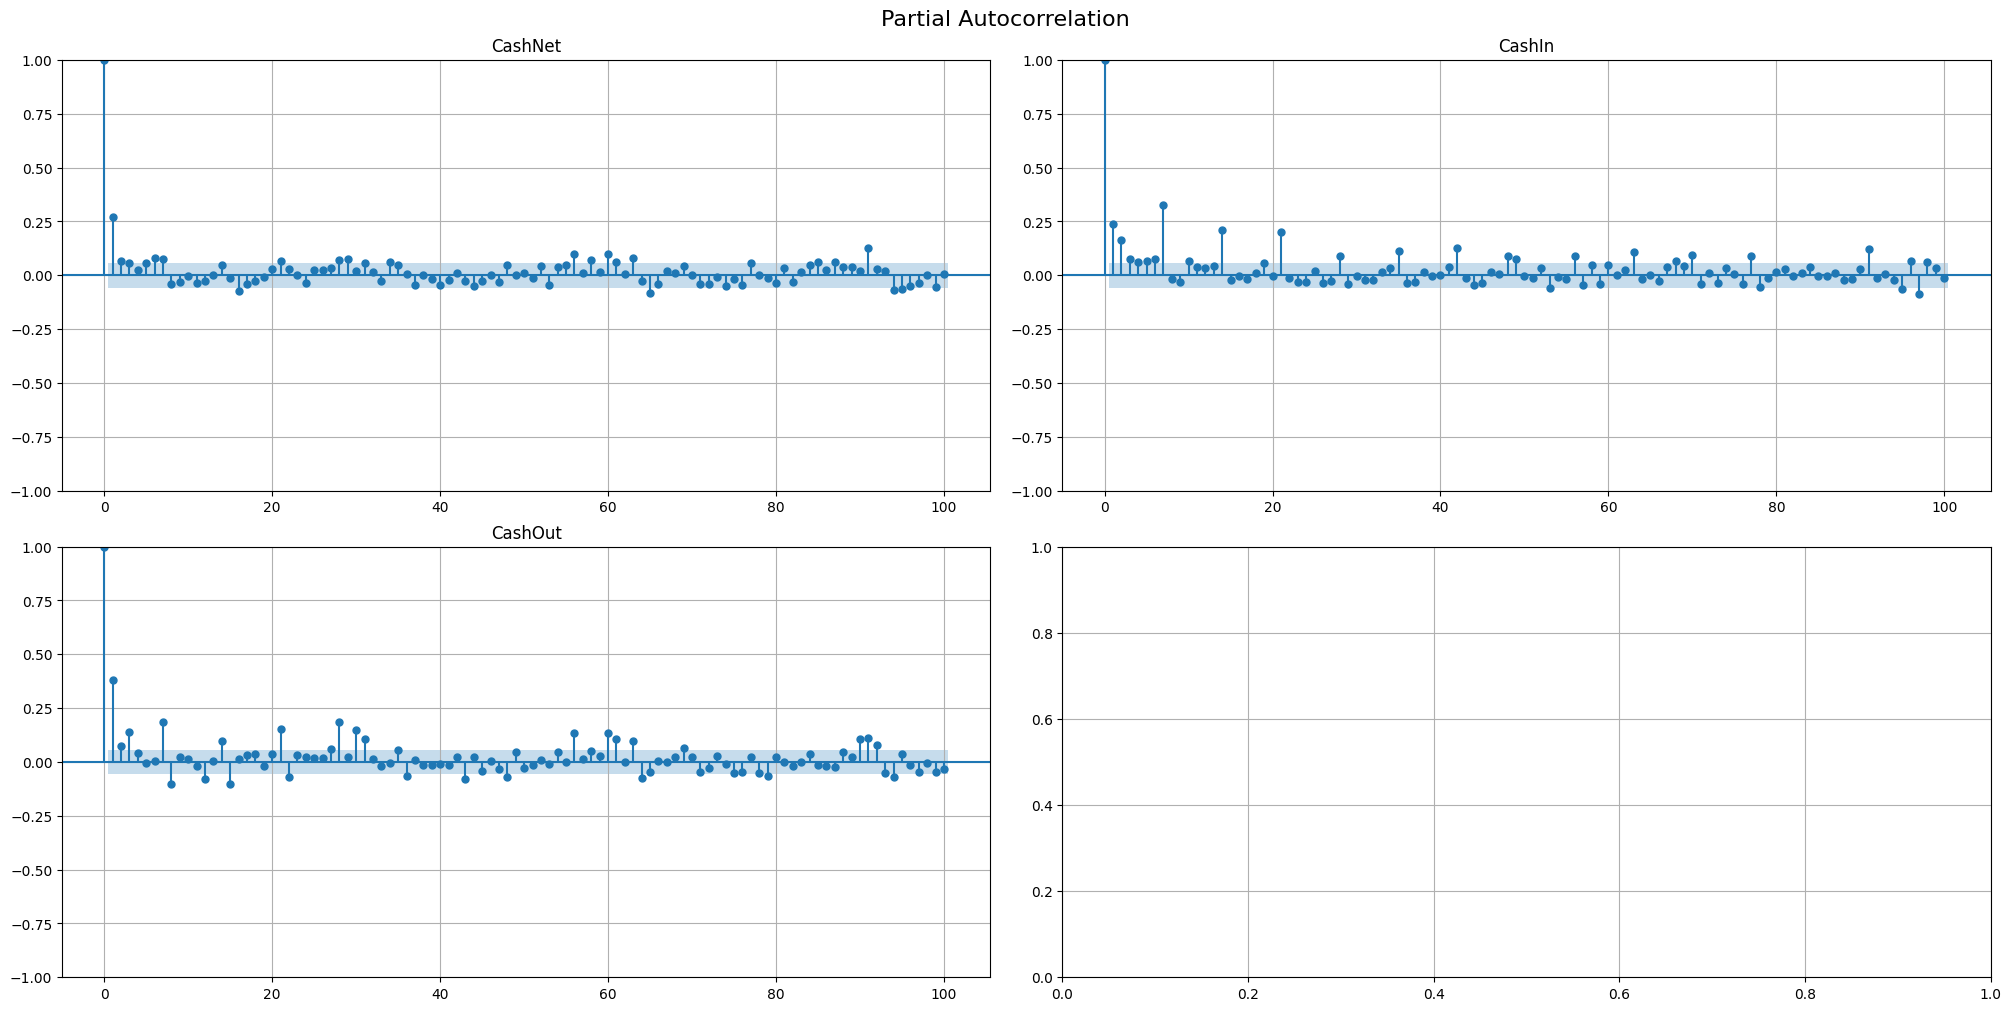

In [ ]:
acf_plot(train_ts, lags=100, partial = True)

По графикам ACF можем наблюдать месячную сезонность (волнообразное поведение), значит в модели **важно учесть лаги приблизительно порядка 25-35**. Также на графиках ACF, PACF для CashIn можно наблюдать большие значения корреляций для каждого 7-ого лага (скорее всего, недельная сезонность). Можно предположить, что такое поведение ACF, PACF связано с днями зарплат и **выходными**.

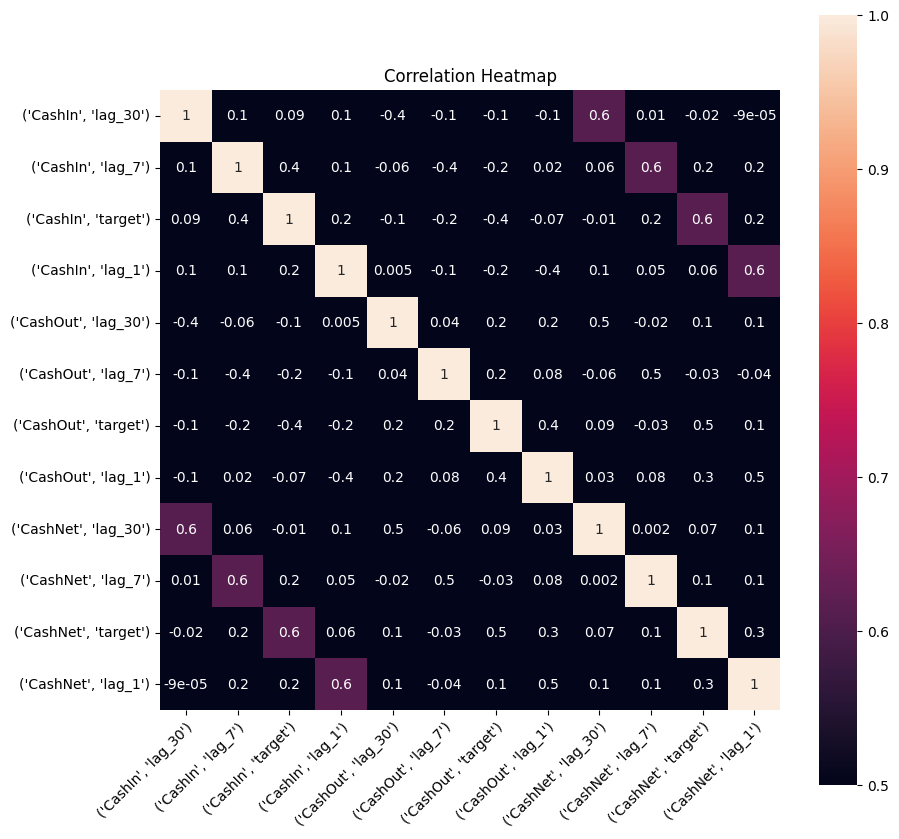

In [ ]:
lags = LagTransform(in_column="target", lags=[1, 7, 30], out_column="lag")
train_ts.fit_transform([lags])

plot_correlation_matrix(
    train_ts, segments=["CashIn", "CashOut", 'CashNet'], method="pearson", vmin=0.5, vmax=1
)

STL

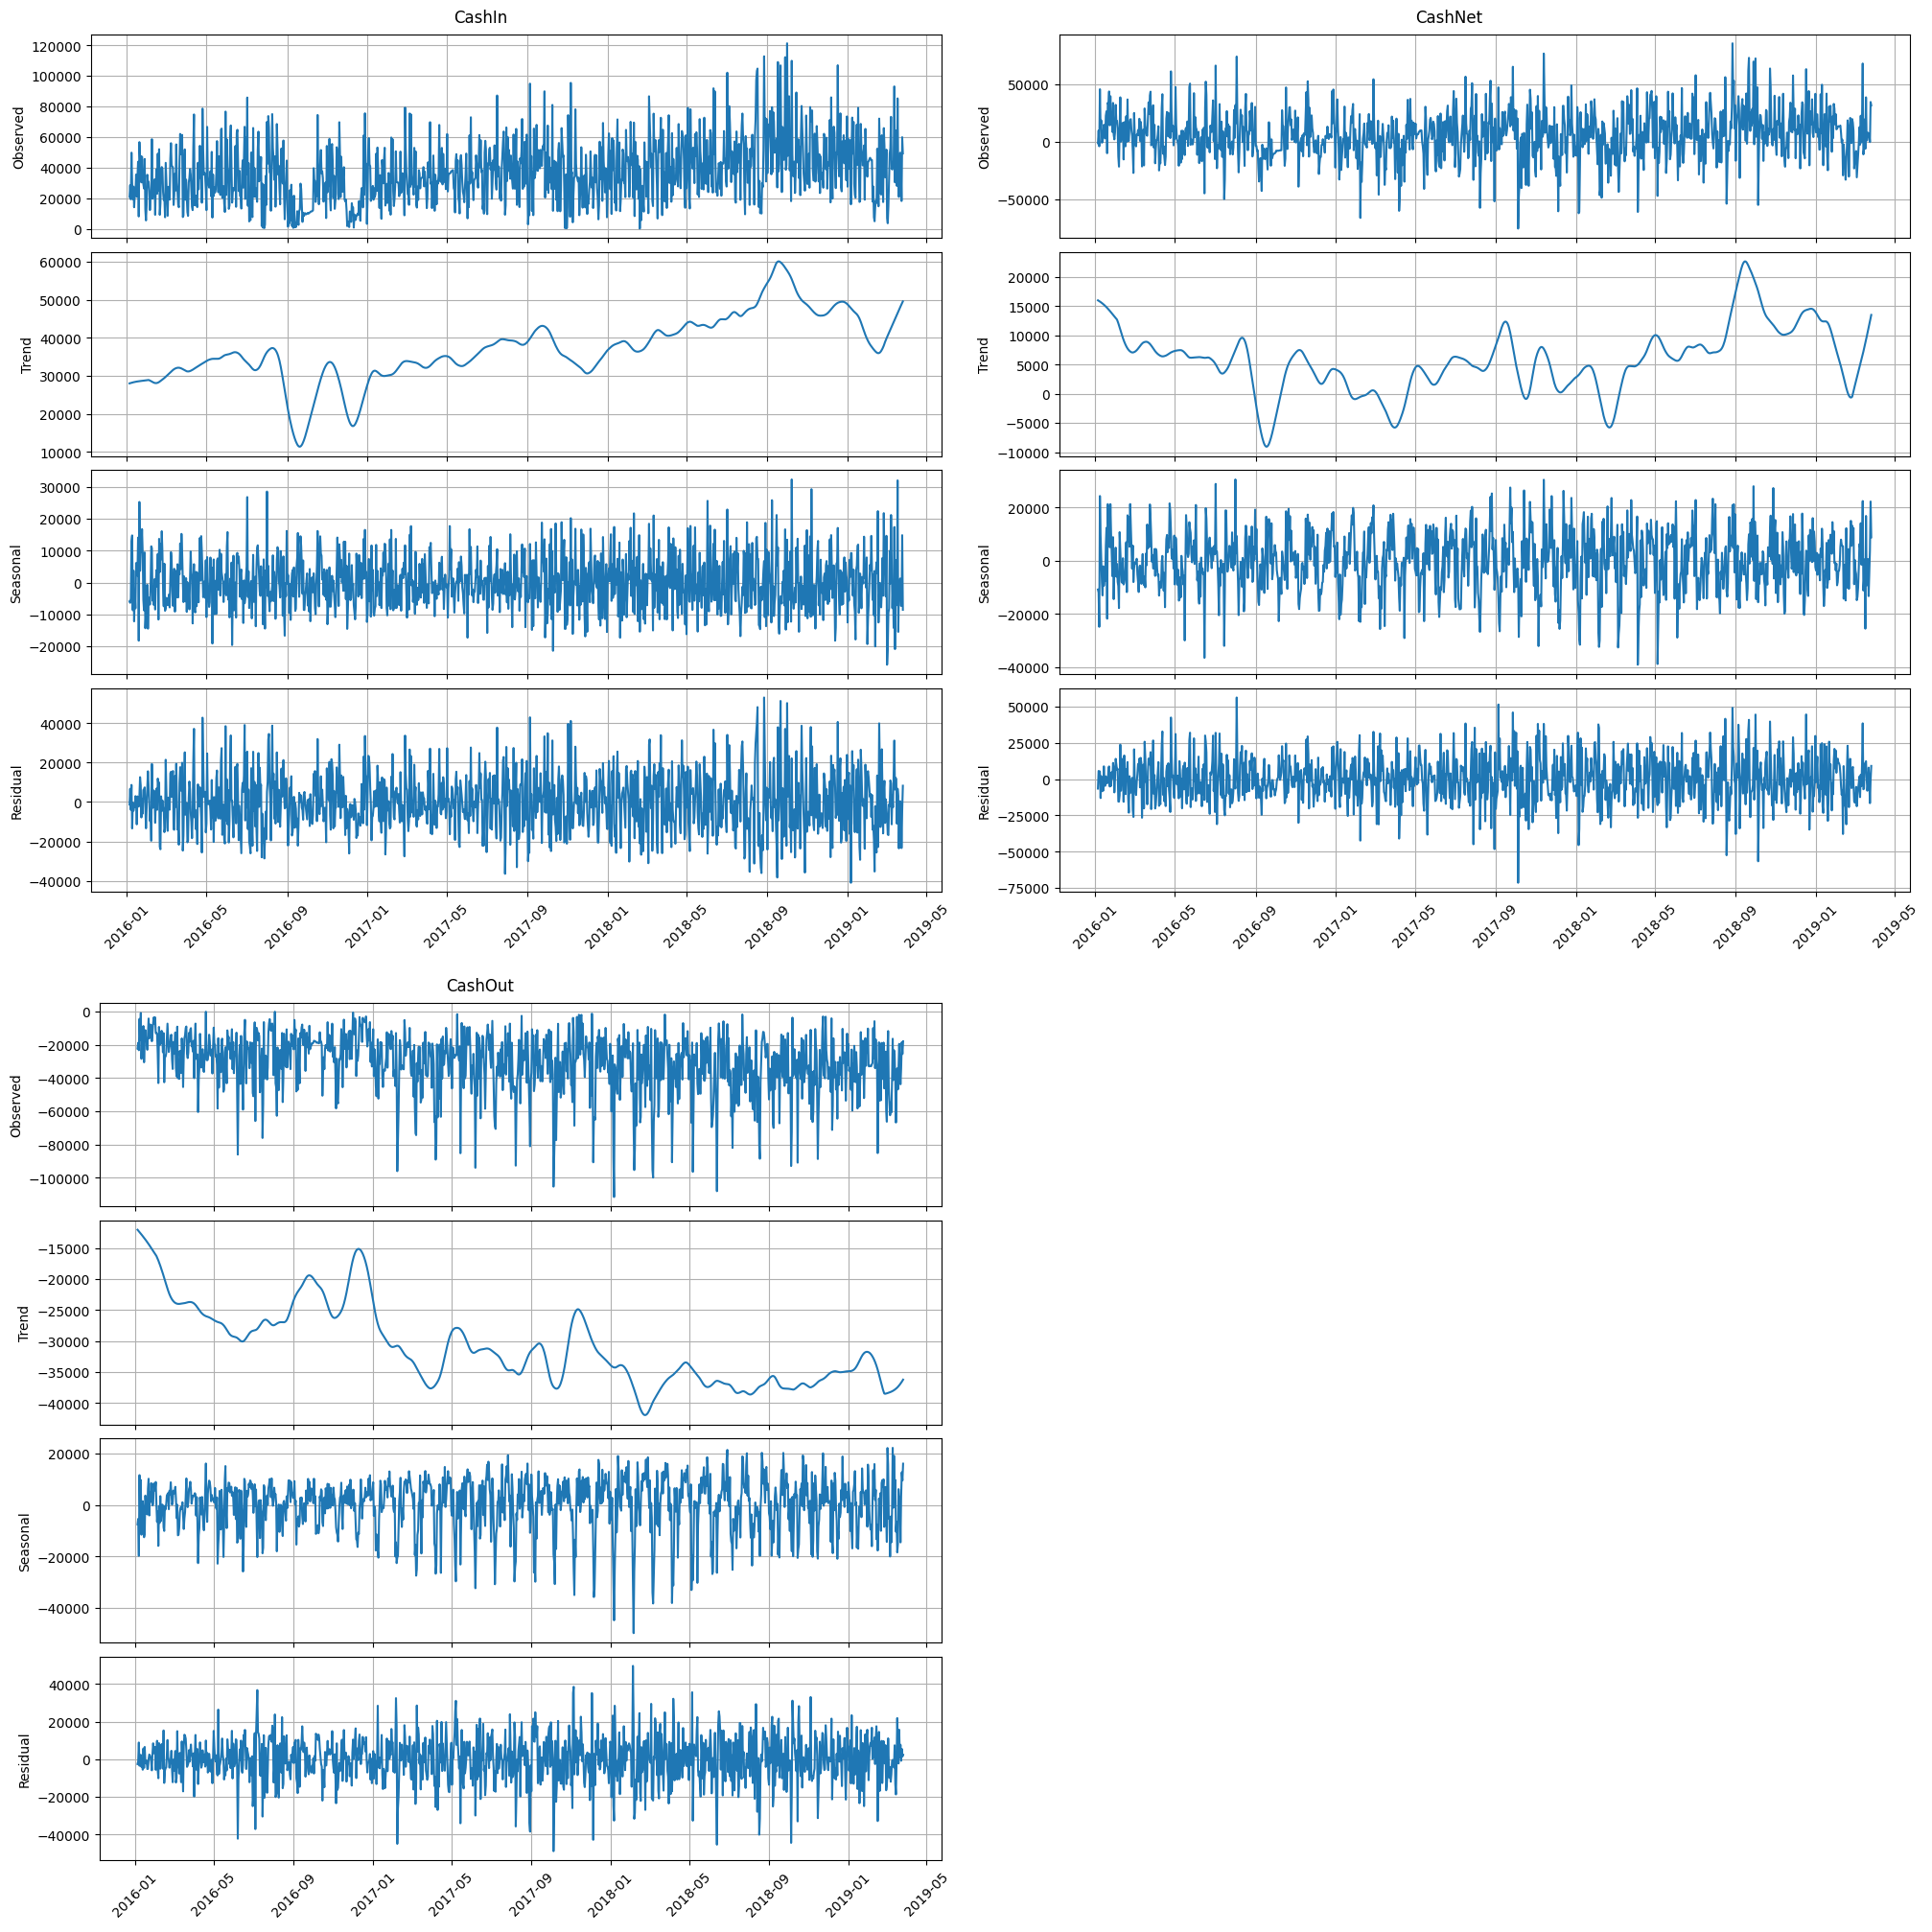

In [ ]:
stl_plot(ts=train_ts, period=30)

**ARIMA**

In [ ]:
horizon = 5  
model = AutoARIMAModel()  
lags = LagTransform(in_column="target", lags=list(range(HORIZON, HORIZON + 7))) # Горизонт прогноза определяет минимальный лаг, 
# которым модель может воспользоваться, поэтому добавляем лаги c 5 по 12 (https://habr.com/ru/companies/tinkoff/articles/657297/) 
# (обнаружили недельную сезонность по графикам PACF)
transforms = [outliers_remover, outliers_imputer, lags]
pipeline = Pipeline(model=model, transforms=transforms, horizon=horizon)

metrics, forecast, fold_info = pipeline.backtest(
    ts=ts2, metrics=[MAE()], aggregate_metrics=True, n_folds = 3
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.3min finished


In [ ]:
metrics

segment           MAE
0   CashIn  13952.527868
1  CashNet  14404.653481
2  CashOut   9439.043350

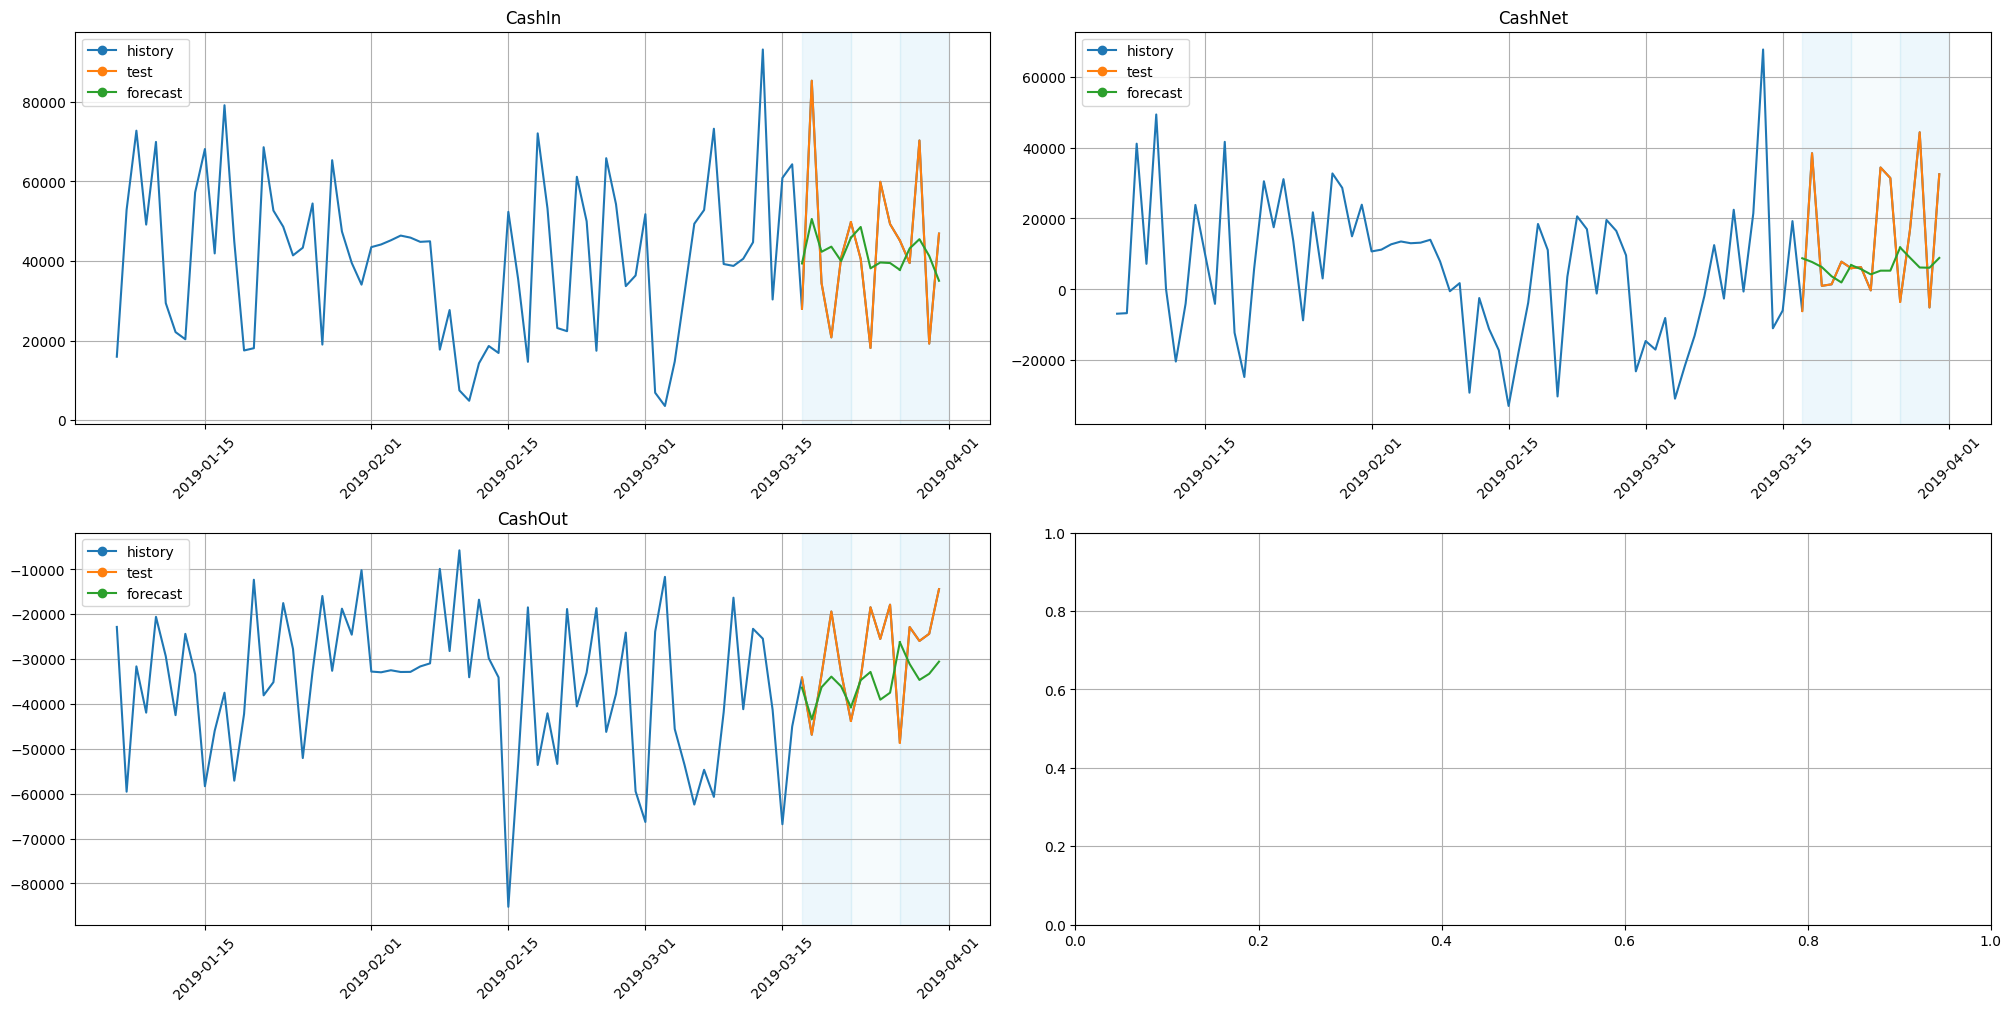

In [ ]:
plot_backtest(forecast_df=forecast, ts=ts2, history_len=70)

**CatBoost**

In [ ]:
stl = STLTransform(in_column="target", period=30, model="arima") # остановимся на месячной сезонности (так как обнаружили ее по графикам ACF)
seg = SegmentEncoderTransform()

lags = LagTransform(in_column="target", lags=list(range(HORIZON, HORIZON + 7))) # Горизонт прогноза определяет минимальный лаг, 
# которым модель может воспользоваться, поэтому добавляем лаги c 5 по 12 (https://habr.com/ru/companies/tinkoff/articles/657297/) 
# (обнаружили недельную сезонность по графикам PACF)
lags30 = LagTransform(in_column="target", lags=list(range(28, 30))) # добавим лаги на конец месяца (дни выплаты зарплат): 
d_flags = DateFlagsTransform(
    day_number_in_week=True, # флаг на день недели (своего рода учет недельной сезонности)
    day_number_in_month=True, # флаг на день месяца (своего рода учет месячной сезонности)
    is_weekend=True, # флаг на выходные дни (значимые лаги)
    special_days_in_week=[6], # флаг на последний день недели (значимый лаг)
)
mean30 = MeanTransform(in_column="target", window=12, seasonality=30) # среднее скользящим окном (своего рода учет месячной сезонности)

# Выплата заработной платы должна производиться не позднее одного раза в месяц. Срок оплаты может быть сокращен до одной недели.
# Источник: https://consultingtr.com/oplata-truda-v-turcii/#:~:text=Выплата%20заработной%20платы%20должна%20производиться,быть%20сокращен%20до%20одной%20недели.

In [ ]:
horizon = 5  
model = CatBoostMultiSegmentModel()  
transforms = [outliers_remover, outliers_imputer, seg, stl, d_flags, lags, lags30, mean30]
pipeline = Pipeline(model=model, transforms=transforms, horizon=horizon)

metrics, forecast, fold_info = pipeline.backtest(
    ts=ts, metrics=[MAE()], aggregate_metrics=True, n_folds = 3
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.0s finished


In [ ]:
metrics

segment           MAE
0   CashIn  19111.110934
1  CashNet  11103.251502
2  CashOut  14187.834521

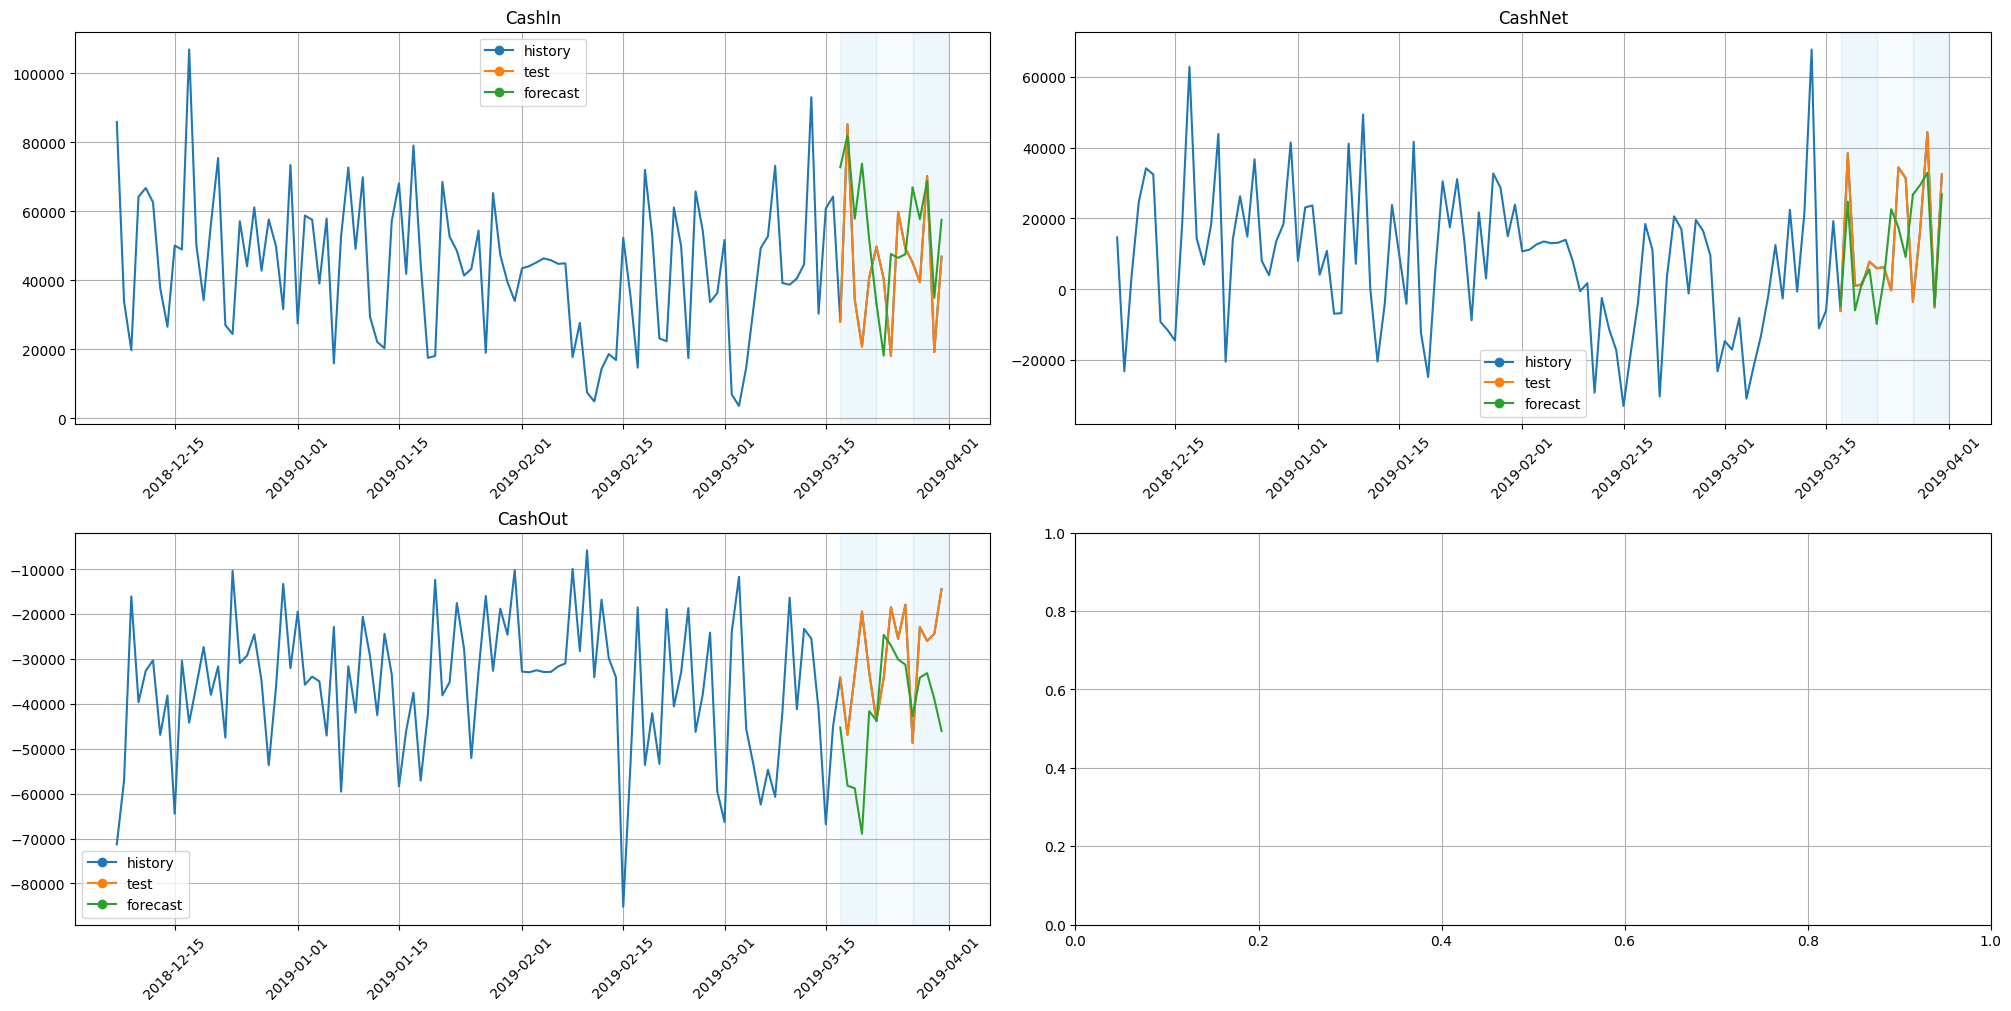

In [ ]:
plot_backtest(forecast_df=forecast, ts=ts2, history_len=100)

Наиболее предсказуемым оказалось снятие наличности, возможно, из-за ярко выраженной месячной сезонности (снятия наличных в дни начисления зарплаты). 

### Задание 7. Стратегии прогнозирования (1.25 балла)

Как нам известно по семинарским занятиям, при построении прогноза на горизонте дальше следующего наблюдения перед нами встает задача определиться со стратегией генерации прогноза. Попробуйте разные стратегии на нашем горизонте из 5 дней (прямая, рекурсивная, смешанная dirrec). Какая стратегия в совокупности с какой моделью дает лучший результат?

Учитывайте особенности, которые некоторые стратегии могут накладывать на признаки (в частности, на лаговые переменные).

При необходимости, в смешанном методе пользуйтесь упрощенной схемой спецификации моделей/преобразований.

In [ ]:
from etna.pipeline import AutoRegressivePipeline, Pipeline, assemble_pipelines
from etna.ensembles import DirectEnsemble

1.1 **ARIMA**: прямая стратегия (обучали выше)

1.   CashIn: 13952.53
2.   CashNet:	14404.65
3.   CashOut	9439.04

1.2 **ARIMA**: рекурсивная стратегия

In [ ]:
model = AutoARIMAModel()  

lags = LagTransform(in_column="target", lags=list(range(HORIZON, HORIZON + 7)))
transforms = [outliers_remover, outliers_imputer, lags]

autoregressivepipeline = AutoRegressivePipeline(
    model=model, transforms=transforms, horizon=HORIZON, step=5
)

metrics_recursive_df, forecast_recursive_df, _ = autoregressivepipeline.backtest(
    ts=ts2, metrics=[MAE()]
)

autoregressive_pipeline_metrics = metrics_recursive_df.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 11.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 14.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 16.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 21.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 21.5min finished


In [ ]:
autoregressive_pipeline_metrics

MAE            13640.09425
fold_number        2.00000
dtype: float64

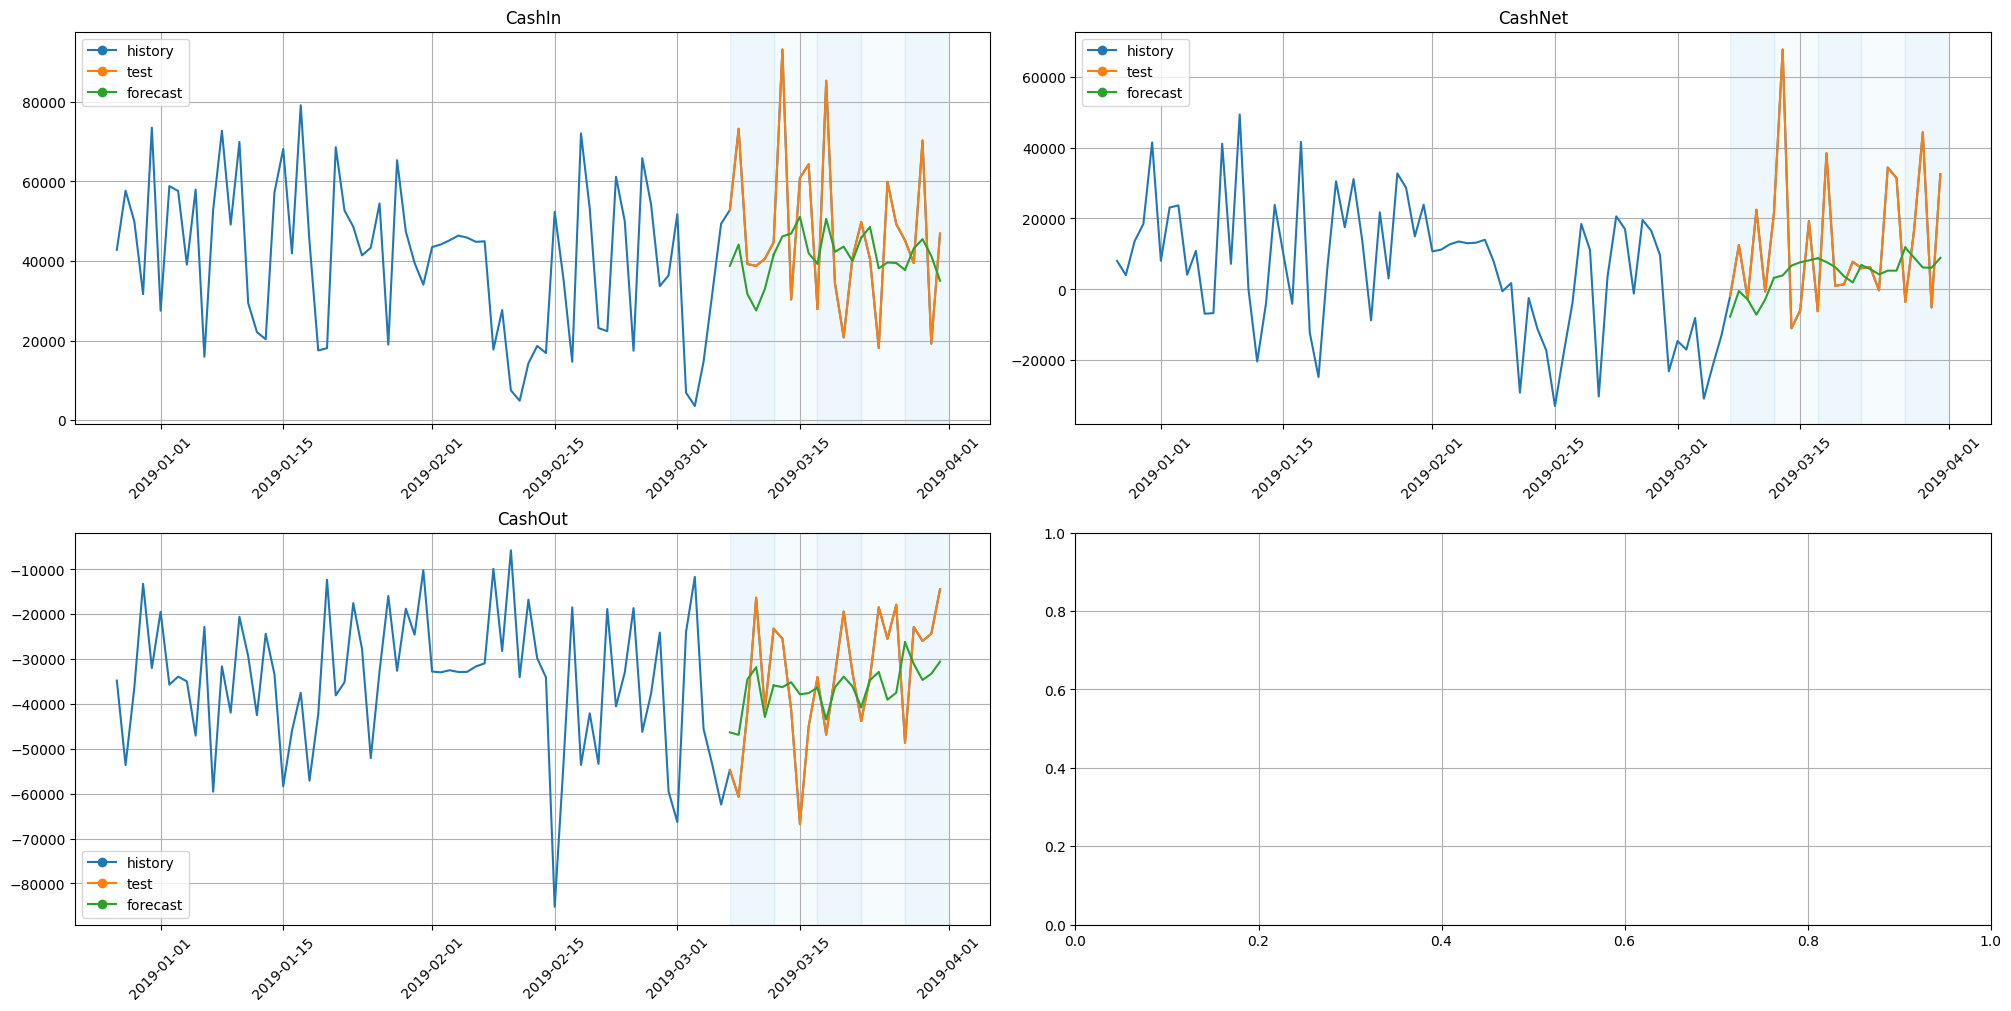

In [ ]:
plot_backtest(forecast_recursive_df, ts2, history_len=70)

1.3 **ARIMA**: смешанная стратегия DirectEnsemble

In [ ]:
horizons = list(range(1, 6))
pipelines_list = []

model = AutoARIMAModel() 

for i in range(HORIZON):
  transforms = [outliers_remover, outliers_imputer, lags]
  pipeline = Pipeline(model=model, transforms=transforms, horizon=horizons[i])
  pipelines_list.append(pipeline)

In [ ]:
ensemble = DirectEnsemble(pipelines = pipelines_list)

metrics_ensemble_df, forecast_ensemble_df, _ = ensemble.backtest(
    ts=ts2, metrics=[MAE()]
)

ensemble_metrics = metrics_ensemble_df.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  8.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 12.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 17.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 21.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 21.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | ela

In [ ]:
ensemble_metrics

MAE            13640.09425
fold_number        2.00000
dtype: float64

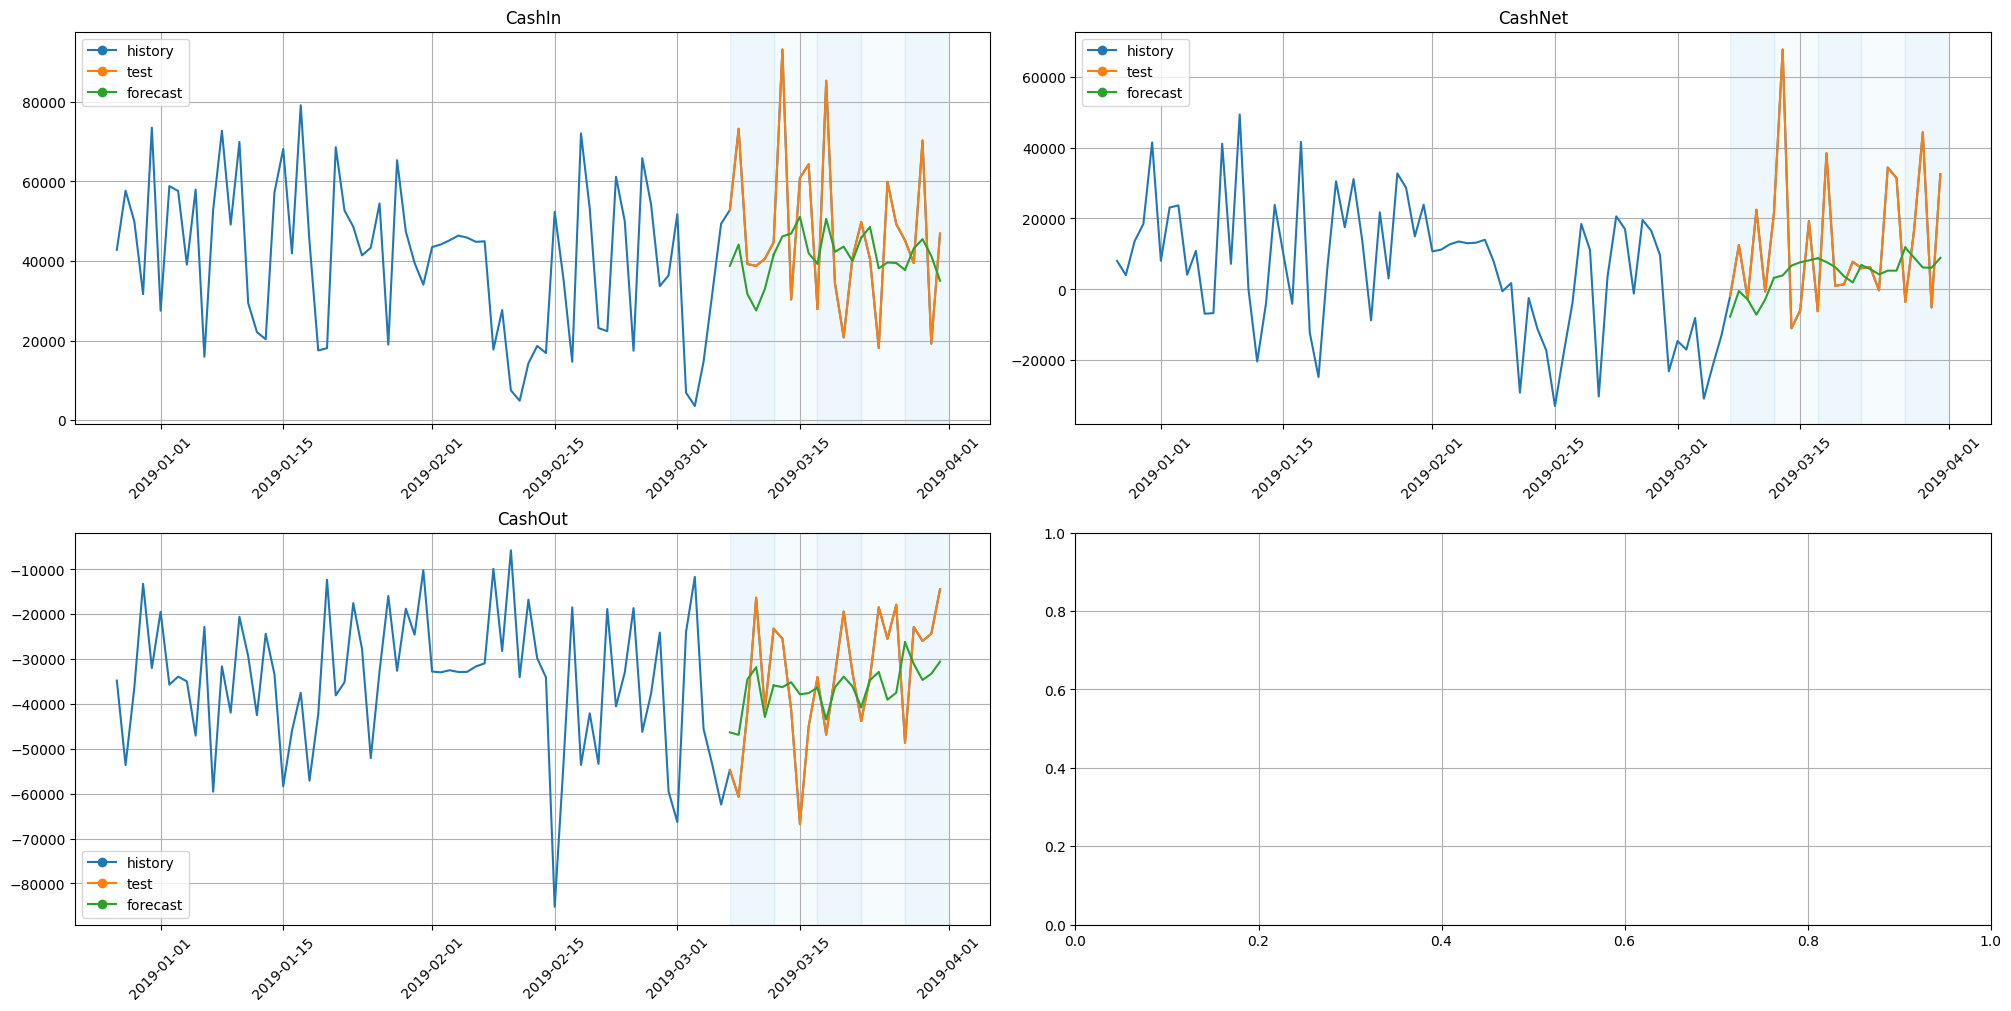

In [ ]:
plot_backtest(forecast_ensemble_df, ts2, history_len=70)

2.1 **CatBoost**: прямая стратегия (обучали выше)



1.   CashIn:	19111.11
2.   CashNet:	11103.25
3.   CashOut:	14187.83



2.2 **CatBoost**: рекурсивная стратегия

In [ ]:
model = CatBoostMultiSegmentModel()  

transforms = [outliers_remover, outliers_imputer, seg, stl, d_flags, lags, lags30, mean30]

autoregressivepipeline = AutoRegressivePipeline(
    model=model, transforms=transforms, horizon=HORIZON, step=1
)

metrics_recursive_df, forecast_recursive_df, _ = autoregressivepipeline.backtest(
    ts=ts, metrics=[MAE()], n_folds = 3
)

autoregressive_pipeline_metrics = metrics_recursive_df.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   25.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   39.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   39.1s finished


In [ ]:
autoregressive_pipeline_metrics

MAE            14800.732319
fold_number        1.000000
dtype: float64

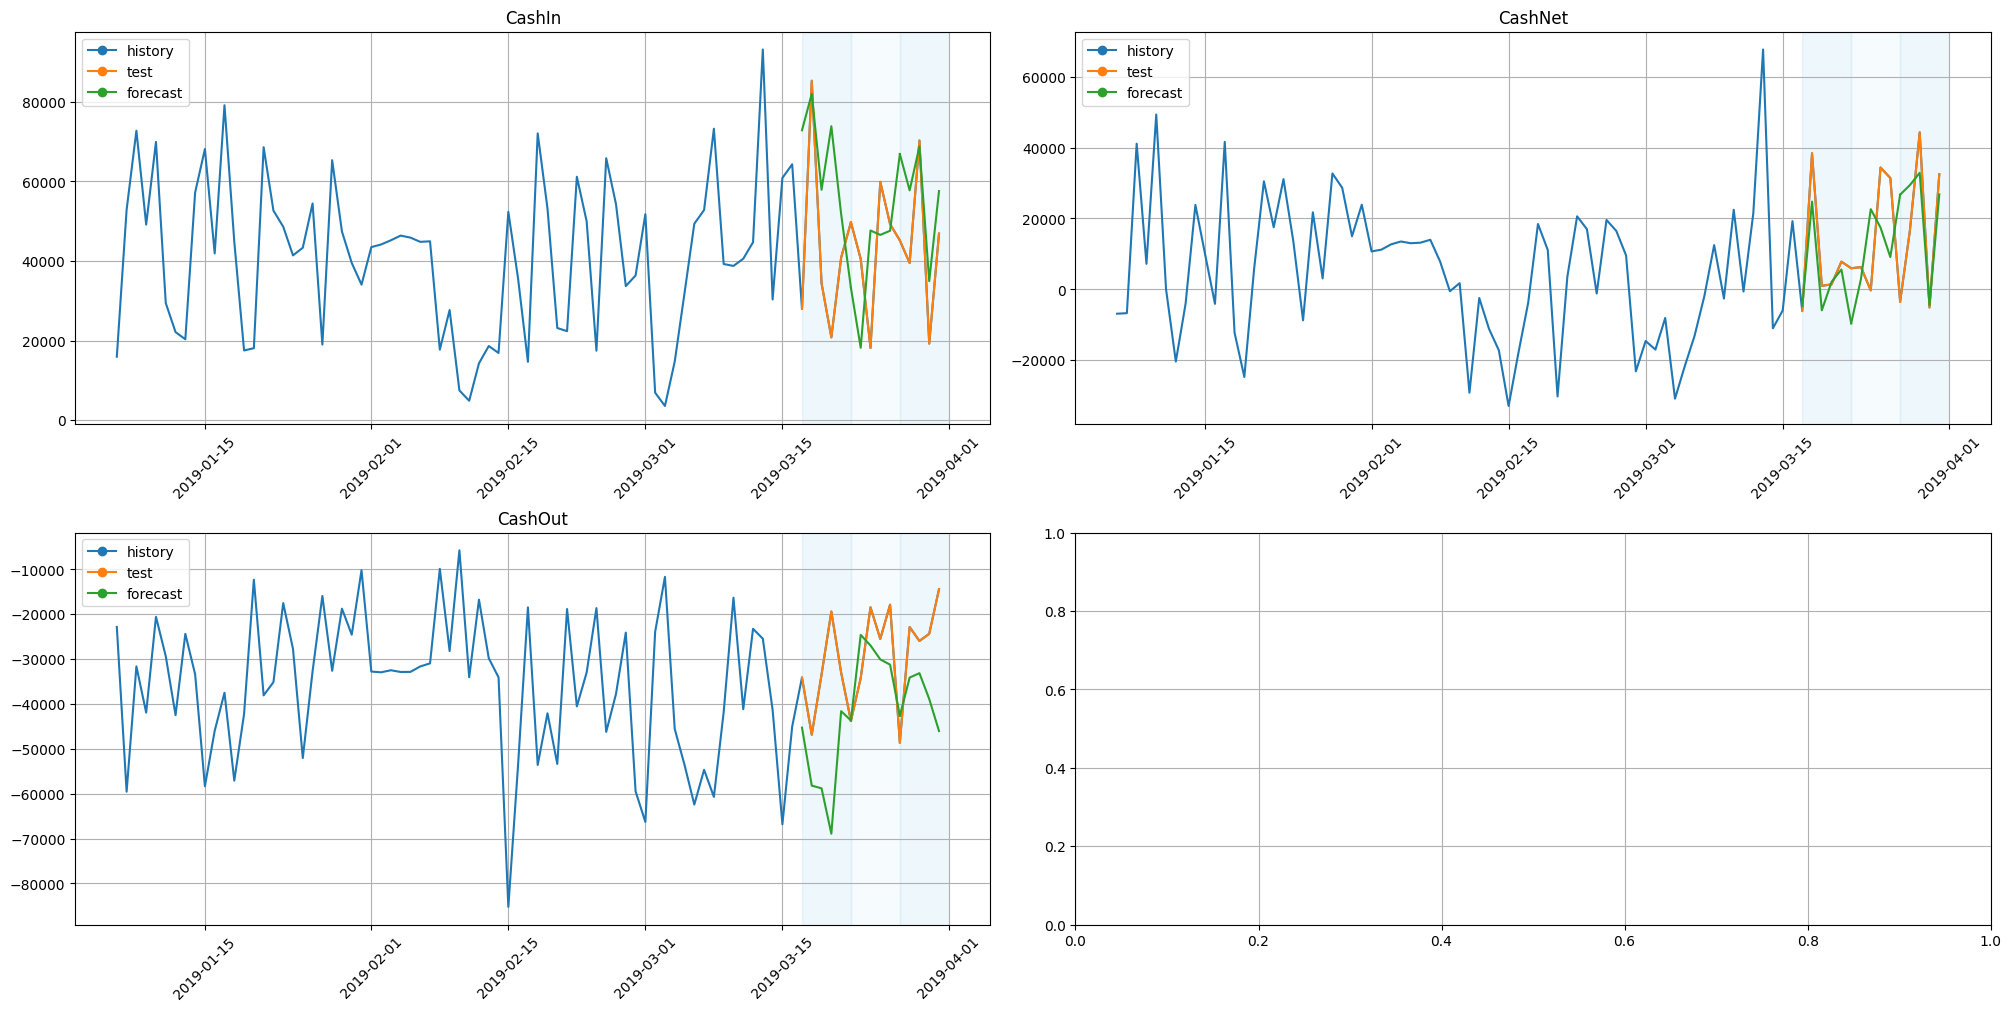

In [ ]:
plot_backtest(forecast_recursive_df, ts2, history_len=70)

2.3 **CatBoost**: смешанная стратегия DirectEnsemble

In [ ]:
horizons = list(range(1, 6))
pipelines_list = []

model = CatBoostModelPerSegment()

for i in range(HORIZON):
  transforms = [outliers_remover, outliers_imputer, seg, stl, d_flags, lags, lags30, mean30]
  pipeline = Pipeline(model=model, transforms=transforms, horizon=horizons[i])
  pipelines_list.append(pipeline)

In [ ]:
ensemble = DirectEnsemble(pipelines = pipelines_list)

metrics_ensemble_df, forecast_ensemble_df, _ = ensemble.backtest(
    ts=ts, metrics=[MAE()], n_folds = 3
)

ensemble_metrics = metrics_ensemble_df.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   39.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   58.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | ela

In [ ]:
ensemble_metrics

MAE            14706.314785
fold_number        1.000000
dtype: float64

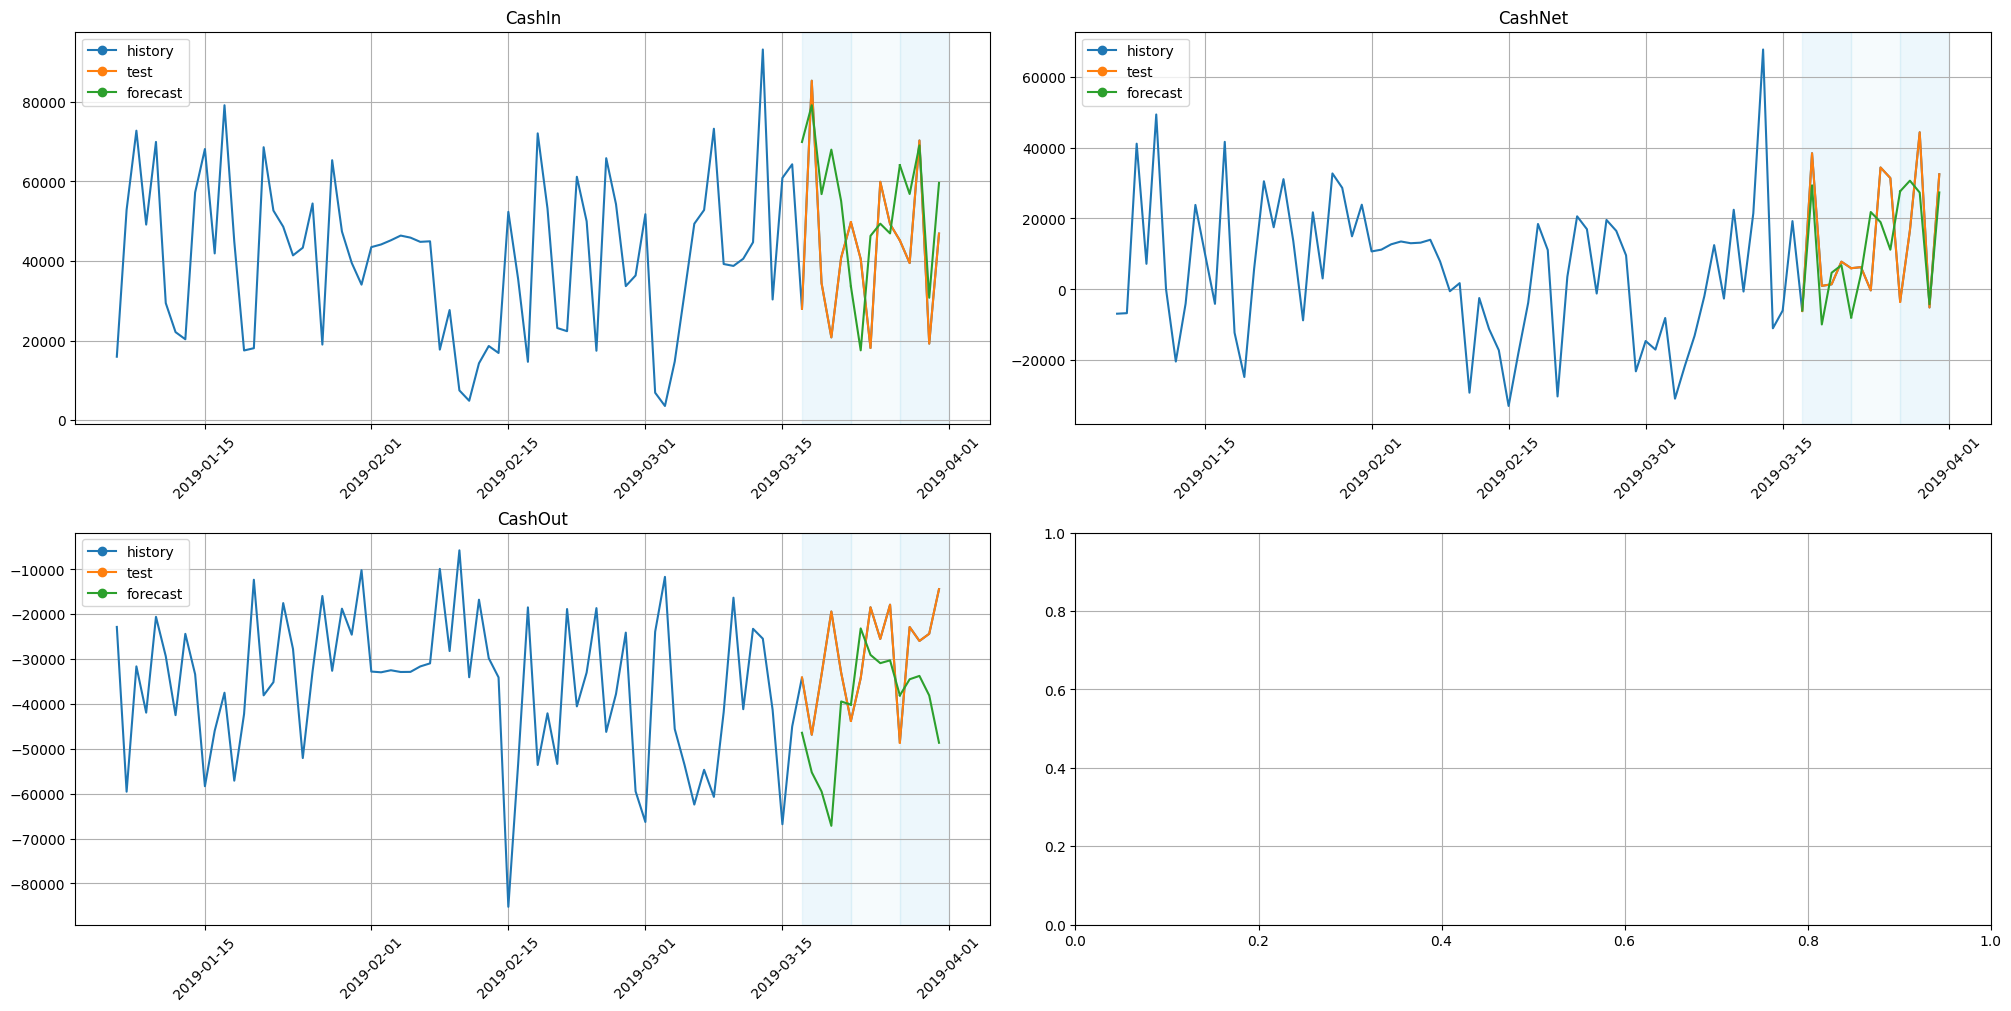

In [ ]:
plot_backtest(forecast_ensemble_df, ts2, history_len=70)

Лучше всего оказался CatBoost со стратегией прямого прогнозирования (для ряда CashNet).

### Задание 8. Ансамбли (1.25 балла)

Чтобы не выбирать лучшую модель, мы можем использовать преимущества каждой - давайте объединим все наши наработки в ансамбль. Попробуйте различные опции ансамблирования, и выберите ту, которая работает лучше всего (не забывайте, что внутри каждого ансамбля у нас тоже есть параметры, которые мы можем варьировать - веса в voting, включаемые признаки в stacking).

In [ ]:
from etna.ensembles import StackingEnsemble, VotingEnsemble

1. VotingEnsemble

In [ ]:
prophet_pipeline = Pipeline(model=ProphetModel(), transforms=[outliers_remover, outliers_imputer], horizon=HORIZON)


arima_pipeline = Pipeline(model=AutoARIMAModel(), transforms=[outliers_remover, outliers_imputer, lags], horizon=HORIZON)

catboost_pipeline = Pipeline(
    model=CatBoostMultiSegmentModel(),
    transforms=[outliers_remover, outliers_imputer, seg, stl, d_flags, lags, lags30, mean30],
    horizon=HORIZON,
)

pipeline_names = ['prophet', 'arima', 'catboost']
pipelines = [prophet_pipeline, arima_pipeline, catboost_pipeline]

In [ ]:
voting_ensemble = VotingEnsemble(pipelines=pipelines, weights=[2, 5, 10], n_jobs=4)

In [ ]:
voting_ensamble_metrics = voting_ensemble.backtest(
    ts=ts,
    metrics=[MAE()],
    n_folds= 3,
    aggregate_metrics=True,
    n_jobs=2,
)[0].iloc[:, 1:]


[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpso638mvo/mtrmwuhp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpso638mvo/_hmmqe6y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpso638mvo/9lqx6lox.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpso638mvo/st2h30y2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57233', 'data', 'file=/tmp/

In [ ]:
voting_ensamble_metrics

MAE
0  15561.496542
1  11768.342115
2  12329.254882

2.1 StackingEnsemble (unfeatured)

In [ ]:
stacking_ensemble_unfeatured = StackingEnsemble(
    pipelines=pipelines, n_folds=3, n_jobs=4
)

In [ ]:
stacking_ensamble_metrics = stacking_ensemble_unfeatured.backtest(
    ts=ts2,
    metrics=[MAE()],
    n_folds=3,
    aggregate_metrics=True,
    n_jobs=2,
)[0].iloc[:, 1:]

stacking_ensamble_metrics # значение метрик идет после warnings

[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpso638mvo/smc9idl3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpso638mvo/ifhmop3q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpso638mvo/fd8o9giv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7

MAE
0  14432.449015
1  14476.016477
2  11633.706456

2.2 StackingEnsemble (featured)

In [128]:
pipelines = [prophet_pipeline, catboost_pipeline]
stacking_ensemble_featured = StackingEnsemble(
    pipelines=pipelines, n_folds=3, n_jobs=4,  features_to_use = [outliers_remover, outliers_imputer, seg, stl, d_flags, lags, lags30, mean30]
)

In [129]:
stacking_ensamble_metrics = stacking_ensemble_featured.backtest(
    ts=ts2,
    metrics=[MAE()],
    n_folds=3,
    aggregate_metrics=True,
    n_jobs=2,
)[0].iloc[:, 1:]

stacking_ensamble_metrics # значение метрик идет после warnings

[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpso638mvo/5hsjmlkt.json
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpso638mvo/4crr_k07.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpso638mvo/ueoftio1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2

MAE
0  11983.834054
1  14435.025594
2  11531.906313

Лучше всего себя показал VotingEnsemble с Prophet, ARIMA и CatBoost моделями и весами [2, 5, 10]. Значение MAE по ряду CashNet чуть больше по сравнению с CatBoost с прямой стратегией прогнозирования, однако, MAE на CashIn, CashOut значительно ниже (скорее всего, из-за ARIMA с лагами 5-12, где в большей степени учитывалась недельная сезонность, отчего метрики на том же CashIn были лучше именно у этой модели по сравнению с CatBoost), a это, в свою очередь, может быть полезно для дальнейшего прогнозирования CashNet.

### Задание 9*. Трансформер (бонус 2 балла)

Для желающих протестировать мощь трансформенных моделей предлагается "завести" модель из второго семинара по временным рядам на текущем датасете. На этот раз абсолютно все необходимые импорты и зависимости подгружаются на ваше усмотрение. Удалось ли вам улучшить качество по сравнению с классическими моделями / моделями на основе ML? Что бы вы предпочли внедрить в production?

*NB:* все, конечно, прекрасно знают механизм работы бонусных заданий, но порядка ряди прописать дисклеймер должны - итоговый балл за домашнее задание ставится по формуле min(10, ваш суммарный балл за задания).

In [ ]:
#YOUR CODE HERE#